This notebook is code for studying the BGS data from the LSS Catalogs prior to running group finding. There are blocks to create the "Merged Files" that are inputs for the preprocessing and groupfinding routines in the GroupCatalog class.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
import astropy.io.fits as fits
from astropy.table import Table,join,vstack,unique,QTable
import sys
from urllib.parse import urljoin
from scipy.ndimage import gaussian_filter
import seaborn as sns
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

if './SelfCalGroupFinder/py/' not in sys.path:
    sys.path.append('./SelfCalGroupFinder/py/')
from pyutils import *
from dataloc import *
from bgs_helpers import *
import groupcatalog as gc
from nnanalysis import *
from plotting import *
from footprintmanager import FootprintManager

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

In [ ]:
KEEP_PASSES = 3
APP_MAG_CUT = 19.5 # BGS BRIGHT, though 19.54 for some cameras. I don't know if FLUX_R has been corrected for this.
#APP_MAG_CUT = 20.175 # BGS FAINT, and in SV3 it is 20.3 instead
Z_MIN = 0.001
Z_MAX = 0.5
KEEP_ONLY_OBSERVED = True

## Make Empty Photo-z Ledger file
 
See photoz.py for the code that populates this file.

In [ ]:
# INITIALIZE LIGHTWEIGHT DESI BGS PHOTO-Z TABLE
# Don't re-run! Will overwrite the file.
"""
desi_table = Table.read(IAN_BGS_Y3_MERGED_FILE, format='fits')
desi_table2 = Table.read(IAN_BGS_SV3_MERGED_NOY3_FILE, format='fits')

assert len(np.unique(desi_table['TARGETID'])) == len(desi_table), "There are duplicate TARGETIDs in the Y3 file"
assert len(np.unique(desi_table2['TARGETID'])) == len(desi_table2), "There are duplicate TARGETIDs in the SV3 file"

desi_table.keep_columns(['TARGETID', 'RA', 'DEC'])
desi_table2.keep_columns(['TARGETID', 'RA', 'DEC'])

desi_targets_table = vstack([desi_table, desi_table2], join_type='inner')
desi_targets_table = unique(desi_targets_table, 'TARGETID')
desi_targets_table['Z_LEGACY_BEST'] = NO_PHOTO_Z

# add columns for 'RELEASE', 'BRICKID', 'OBJID', 'REF_CAT', 'MATCH_DIST' with no values
desi_targets_table.add_column(np.zeros(len(desi_targets_table), dtype=int), name='RELEASE')
desi_targets_table.add_column(np.zeros(len(desi_targets_table), dtype=int), name='BRICKID')
desi_targets_table.add_column(np.zeros(len(desi_targets_table), dtype=int), name='OBJID')
desi_targets_table.add_column(np.zeros(len(desi_targets_table), dtype='S2'), name='REF_CAT')
desi_targets_table.add_column(np.full(len(desi_targets_table), 999999, dtype=float), name='MATCH_DIST')


desi_targets_table = desi_targets_table.to_pandas()
desi_targets_table.set_index('TARGETID', inplace=True)
pickle.dump(desi_targets_table, open(IAN_PHOT_Z_FILE, 'wb'))
"""


In [ ]:
# Read BGS_IMAGES_FOLDER + "terminal.txt" into an array of strings, 1 per line
f = open(BGS_IMAGES_FOLDER + "terminal.txt", "r")
lines = f.readlines()
f.close()

# Now filter it down to ones like this:
#Start processing brick #X
#Matched 0 out of Z
#start_lines = [line for line in lines if "Start processing brick" in line]
matched_lines = [line for line in lines if "Matched" in line]

#print(len(start_lines))
print(len(matched_lines))

# Extract X, Y, Z from each line 
#start_lines = [line.split()[3] for line in start_lines]    
matched_lines = [int(line.split()[1]) for line in matched_lines]

# Strip away # and convert to int
#start_lines = [int(line[1:]) for line in start_lines]

# The index is the brick number for matched_lines
# Find the brick numbers where the value is 0 and remember those indexes
zero_indexes = [i for i in range(len(matched_lines)) if matched_lines[i] == 0]

#pickle.dump(zero_indexes, open(BRICKS_TO_SKIP_S_FILE, 'wb'))

In [ ]:
#pickle.dump([], open(BRICKS_TO_SKIP_N_FILE, 'wb'))

## Build other support files

In [ ]:
build_sv3_clustering_randoms_files()

In [ ]:
build_sv3_full_randoms_files()

In [ ]:
# Make a file with just TARGETID and QUIESCENT columns to send to Joe for Clustering
tbl = Table.read(IAN_BGS_Y3_MERGED_FILE_LOA, format='fits') 
tbl.keep_columns(['TARGETID', 'QUIESCENT'])
tbl.write(BGS_Y3_FOLDER_LOA + "COLOR_LOOKUP_LOA.fits", format='fits', overwrite=True)

# Examine data in a Merged BGS File (SV3, Y1, Y3, whatever)

In [ ]:
# Pick one
#table = Table.read(IAN_BGS_SV3_MERGED_FILE, format='fits')
#table = Table.read(IAN_BGS_SV3_MERGED_NOY3_FILE, format='fits')
table = Table.read(IAN_BGS_Y1_MERGED_FILE, format='fits')
#table = Table.read(IAN_BGS_Y3_MERGED_FILE_LOA, format='fits')

#table = Table.read(IAN_BGS_SV3_MERGED_FULL_FILE, format='fits')

### Feather experiment

In [ ]:
import time

import pyarrow.feather as feather
names = [name for name in table.colnames if len(table[name].shape) <= 1]


# Convert Astropy Table to pandas DataFrame if not already
start = time.time()
if not isinstance(table, pd.DataFrame):
    df_arrow = table[names].to_pandas()
else:
    df_arrow = table
end = time.time()
print(f"Conversion to pandas DataFrame time: {end - start:.4f} seconds)

# Write to feather file
start = time.time()
feather_file = "table_perf_test.feather"
df_arrow.reset_index(drop=True, inplace=True)
feather.write_feather(df_arrow, feather_file)
end = time.time()
print(f"Feather write time: {end - start:.4f} seconds")

# Perf test: read the feather file
start = time.time()
df_read = feather.read_feather(feather_file)
end = time.time()
print(f"Feather read time: {end - start:.4f} seconds")

In [ ]:
import time

start = time.time()
table_orig = Table.read(IAN_BGS_Y1_MERGED_FILE, format='fits')
end = time.time()
print(f"Original FITS read time: {end - start:.4f} seconds")
print(f"Rows read: {len(table_orig)}")

## Cut to the galaxy data we actually need

In [ ]:
# TODO this gets easilly out of sync with the .py file that does the 'production' filtering
z_obs = get_tbl_column(table, 'Z', required=True)
obj_type = get_tbl_column(table, 'SPECTYPE', required=True)
unobserved = determine_unobserved_from_z(z_obs)
deltachi2 = get_tbl_column(table, 'DELTACHI2', required=True)
maskbits = get_tbl_column(table, 'MASKBITS')
dec = table['DEC'].astype("<f8")
ra = table['RA'].astype("<f8")
z_phot = table['Z_PHOT'].astype("<f8")
target_id = table['TARGETID']
app_mag_r = table['APP_MAG_R']
app_mag_g = table['APP_MAG_G']
g_r_apparent = app_mag_g - app_mag_r
abs_mag_r = table['ABS_MAG_R']
abs_mag_g = table['ABS_MAG_G']
#sdss_g_r = table['ABSMAG_SDSS_G'] - table['ABSMAG_SDSS_R'] 
G_R_JM1 = table['ABSMAG01_SDSS_G'] - table['ABSMAG01_SDSS_R']
p_obs = table['PROB_OBS'] 
ntiles = table['NTILE'].astype("<i8")
#tiles = table['TILES']
tile_id = table['TILEID'] if 'TILEID' in table.columns else None
#numobs = table['NUMOBS']
#tile_locid = table['TILELOCID']
ntiles_mine = table['NTILE_MINE']
tileids = table['NEAREST_TILEIDS'][:,0].astype("<i8") # TODO there are 10 here, we want NTILES_MINE many...
#abs_mag_sdss = table['ABSMAG_SDSS_R']
dn4000 = get_tbl_column(table, 'DN4000_MODEL')
ref_cat = table['REF_CAT']
quiescent = table['QUIESCENT']
photsys = get_tbl_column(table, 'PHOTSYS', required=True)


before_count = len(dec)
print(before_count, "objects in FITS file")

# TODO BUG Can we be mistaking STARS for GALAXIES?
# Make filter array (True/False values)
PASSES_REQUIRED = [1,2,3,4,10]

galaxy_observed_filter = obj_type == b'GALAXY'
app_mag_filter = np.where(photsys == b'N', app_mag_r < APP_MAG_CUT+0.04, app_mag_r < APP_MAG_CUT)
redshift_filter = z_obs > Z_MIN
redshift_hi_filter = z_obs < Z_MAX
deltachi2_filter = deltachi2 > 40
#abs_mag_sdss_filter = abs_mag_sdss < 100
#observed_requirements = np.all([galaxy_observed_filter, app_mag_filter, redshift_filter, redshift_hi_filter, deltachi2_filter, abs_mag_sdss_filter], axis=0)
observed_requirements = np.all([galaxy_observed_filter, app_mag_filter, redshift_filter, redshift_hi_filter, deltachi2_filter], axis=0)

treat_as_unobserved = np.all([galaxy_observed_filter, app_mag_filter, np.invert(deltachi2_filter)], axis=0)

unobserved = np.all([app_mag_filter, np.logical_or(unobserved, treat_as_unobserved)], axis=0)
keep = np.all([np.logical_or(observed_requirements, unobserved)], axis=0)

print("\nWhole sample:")
print(f"There are {len(obj_type):,} objects in the entire sample, of which {np.sum(galaxy_observed_filter):,} are observed galaxies.") 

for n in PASSES_REQUIRED:
    n_pass_filter = ntiles_mine >= n
    n_pass_filter_old = ntiles >= n
    unobserved_n = np.all([n_pass_filter, unobserved], axis=0)
    observed_requirements_n = np.all([n_pass_filter, observed_requirements], axis=0)
    keepn = np.all([np.logical_or(observed_requirements_n, unobserved_n)], axis=0)

    print(f"\n{n}-pass analysis (NTILE_MINE):")
    print(f"There are {np.sum(observed_requirements_n):,} galaxies in the <{APP_MAG_CUT} mag sample that pass our quality checks.")
    print(f"There are {np.sum(unobserved_n):,} unobserved galaxies, including bad observed galaxies.")
    print(f"This {n}-pass catalog would have {np.sum(keepn):,} galaxies ({np.sum(unobserved_n) / np.sum(keepn) * 100:.2f}% lost).")

    # We've demonstratred this is definetely not what we want
    #unobserved_n_old = np.all([n_pass_filter_old, unobserved], axis=0)
    #observed_requirements_n_old = np.all([n_pass_filter_old, observed_requirements], axis=0)
    #keepn_old = np.all([np.logical_or(observed_requirements_n_old, unobserved_n_old)], axis=0)
    #print(f"\n{n}-pass analysis (NTILE):")
    #print(f"There are {np.sum(observed_requirements_n_old):,} galaxies in the bright (<{APP_MAG_CUT} mag) sample that pass our quality checks.")
    #print(f"There are {np.sum(unobserved_n_old):,} unobserved galaxies, including bad observed galaxies.")
    #print(f"This {n}-pass catalog would have {np.sum(keepn_old):,} galaxies ({np.sum(unobserved_n_old) / np.sum(keepn_old) * 100:.2f}% lost).")

if KEEP_ONLY_OBSERVED:
    keep = np.all([keep, ntiles_mine >= KEEP_PASSES, ~unobserved], axis=0)
else:
    keep = np.all([keep, ntiles_mine >= KEEP_PASSES], axis=0)

obj_type = obj_type[keep]
dec = dec[keep]
ra = ra[keep]
z_phot = z_phot[keep]
z_obs = z_obs[keep]
target_id = target_id[keep] 
app_mag_r = app_mag_r[keep]
app_mag_g = app_mag_g[keep]
g_r_apparent = g_r_apparent[keep]
p_obs = p_obs[keep]
unobserved = unobserved[keep]
deltachi2 = deltachi2[keep]
ntiles = ntiles[keep]
abs_mag_r = abs_mag_r[keep]
abs_mag_g = abs_mag_g[keep]
#tiles = tiles[keep]
#ztileid = ztileid[keep]
ntiles_mine = ntiles_mine[keep]
tileids = tileids[keep]
tile_id = tile_id[keep] if 'TILEID' in table.columns else None
#numobs = numobs[keep]
#tile_locid = tile_locid[keep]
#abs_mag_sdss = abs_mag_sdss[keep]
#sdss_g_r = sdss_g_r[keep]
G_R_JM1 = G_R_JM1[keep]
dn4000 = dn4000[keep]
ref_cat = ref_cat[keep]
maskbits = maskbits[keep]
indexes_not_assigned = np.flatnonzero(unobserved)
quiescent = quiescent[keep]

after_count = len(dec)

print(f"\nAfter all filters we have {after_count:,} of the original {before_count:,} rows.")

In [ ]:
# This reproduces the above.
names = [name for name in table.colnames if len(table[name].shape) <= 1]
df = table[names].to_pandas()
df = df[np.where(df['PHOTSYS'] == b'N', df['APP_MAG_R'] < APP_MAG_CUT+0.04, df['APP_MAG_R'] < APP_MAG_CUT)]
df['UNOBSERVED'] = determine_unobserved_from_z(df['Z'])

galaxy_observed_filter = df['SPECTYPE'] == b'GALAXY'
deltachi2_filter = df['DELTACHI2'] > 40
observed_requirements = galaxy_observed_filter & (df['Z'] > Z_MIN) & (df['Z'] < Z_MAX) & deltachi2_filter
treat_as_unobserved = np.all([galaxy_observed_filter, np.invert(deltachi2_filter)], axis=0)

df['UNOBSERVED'] = df['UNOBSERVED'] | treat_as_unobserved
keep = np.all([np.logical_or(observed_requirements, df['UNOBSERVED'])], axis=0)

if KEEP_ONLY_OBSERVED:
    keep = np.all([keep, df['NTILE_MINE'] >= KEEP_PASSES, ~df['UNOBSERVED']], axis=0)
else:
    keep = np.all([keep, df['NTILE_MINE'] >= KEEP_PASSES], axis=0)

df = df[keep]
print(len(df))

#df['SSFR'] = df['SFR'] / np.power(10, df['LOGMSTAR'])

In [ ]:
# Test that the overall target density in photsys N vs S is within 1% of each other
mgr = FootprintManager()
Ndeg = mgr.get_footprint('Y1', 'N', KEEP_PASSES)
Sdeg = mgr.get_footprint('Y1', 'S', KEEP_PASSES)
n_density = np.sum(df['PHOTSYS'] == b"N") / Ndeg
s_density = np.sum(df['PHOTSYS'] == b"S") / Sdeg
print(f"Target density in N: {n_density:.4f} targets/deg^2")
print(f"Target density in S: {s_density:.4f} targets/deg^2")
if np.abs(n_density - s_density) / ((n_density + s_density) / 2) > 0.01:
    print(f"WARNING: Target density in N and S is more than 1% different.")

### Maps

In [ ]:
# Make maps
two_pass_filter = ntiles_mine >= 2 
three_pass_filter = ntiles_mine >= 3 
four_pass_filter = ntiles_mine >= 4 

ra2 = ra[two_pass_filter]
dec2 = dec[two_pass_filter]
tileids2 =  tileids[two_pass_filter]
unobserved2 = unobserved[two_pass_filter]

ra3 = ra[three_pass_filter]
dec3 = dec[three_pass_filter]
tileids3 =  tileids[three_pass_filter]
unobserved3 = unobserved[three_pass_filter]

ra4 = ra[four_pass_filter]
dec4 = dec[four_pass_filter]
tileids4 =  tileids[four_pass_filter]
unobserved4 = unobserved[four_pass_filter]

one_pass_df = pd.DataFrame({'RA': ra, 'DEC': dec, 'Z_ASSIGNED_FLAG': unobserved, 'TILEID': tileids})
two_pass_df = pd.DataFrame({'RA': ra[two_pass_filter], 'DEC': dec[two_pass_filter], 'Z_ASSIGNED_FLAG': unobserved2, 'TILEID': tileids2})
three_pass_df = pd.DataFrame({'RA': ra3, 'DEC': dec3, 'Z_ASSIGNED_FLAG': unobserved3, 'TILEID': tileids3})
four_pass_df = pd.DataFrame({'RA': ra4, 'DEC': dec4, 'Z_ASSIGNED_FLAG': unobserved4, 'TILEID': tileids4})

small = df['RA'] > 160
small &= df['RA'] < 175
small &= df['DEC'] > -7
small &= df['DEC'] < 3
small_df = df.loc[small]

fig=make_map(ra, dec)
fig=make_map(ra3, dec3, fig=fig, alpha=0.1)
fig=make_map(small_df['RA'], small_df['DEC'], fig=fig, alpha=0.1)

In [ ]:
tiles_BGS = read_tiles_Y1_main()
plot_positions(one_pass_df, three_pass_df, tiles_df=tiles_BGS, DEG_LONG=5, split=False)


In [ ]:
# See where missing photo-z's are
#idx_no_zphot = z_phot == NO_PHOTO_Z
#no_photoz_df = pd.DataFrame({'RA': ra[idx_no_zphot], 'DEC': dec[idx_no_zphot], 'Z_ASSIGNED_FLAG': unobserved[idx_no_zphot], 'TILEID': tileids[idx_no_zphot]})
#plot_positions(one_pass_df, no_photoz_df, tiles_df=tiles_BGS, DEG_LONG=3, split=False)

fig=make_map(ra3, dec3, dpi=300, alpha=0.02)
#ra_4 = ra[four_pass_filter]
#dec_4 = dec[four_pass_filter]
#print(f"Number of 4-pass galaxies: {len(ra_4)}, number of 3-pass galaxies: {len(ra)}")
#fig=make_map(ra[idx_no_zphot], dec[idx_no_zphot], fig=fig, alpha=0.1)
#fig=make_map(ra[ntiles_mine >= 10 ], dec[ntiles_mine >= 10 ], fig=fig, alpha=0.2)



In [ ]:
make_map(ra, dec, fig=fig, alpha=0.02)

In [ ]:
plt.hist(table['ABSMAG01_SDSS_R'], bins=100, range=(-25, -15))

### Make Spectroscopic Properties Lookup Table
For lost galaxies we want a Dn4000 value and stellar mass. But they have no spectra. So, using their k-corrected g-r color and their absolute magnitude (once a z is assigned to them), we can assigned a random Dn4000 based on similar observed galaxies. This approach helps keep whatever systematics are associated with out quiesence determination similar between lost and observed galaxies.

In [ ]:
# This was run over the usual redshift range, 0.001 < z < 0.5, for Y3 Loa Observed Galaxies to a magnitude of 20.0
# Prepare the data for KDTree
goodidx = ~np.isnan(df['ABSMAG01_SDSS_R']) & ~np.isnan(df['G_R_BEST']) & ~np.isnan(df['DN4000_MODEL']) & ~np.isnan(df['LOG_L_GAL']) & ~np.isnan(df['LOGMSTAR'])
METRIC_MAG = 1
METRIC_GMR = 5

print("Middle 50% range")
r1 = np.percentile(df.loc[goodidx, 'ABS_MAG_R'], [25, 75])
r2 = np.percentile(df.loc[goodidx, 'G_R_BEST'], [25, 75])
print((r1[1] - r1[0]) * METRIC_MAG)
print((r2[1] - r2[0]) * METRIC_GMR)

print("Middle 80% range")
r1 = np.percentile(df.loc[goodidx, 'ABS_MAG_R'], [10, 90])
r2 = np.percentile(df.loc[goodidx, 'G_R_BEST'], [10, 90])
print((r1[1] - r1[0]) * METRIC_MAG)
print((r2[1] - r2[0]) * METRIC_GMR)

print("Middle 95% range")
r1 = np.percentile(df.loc[goodidx, 'ABS_MAG_R'], [2.5, 97.5])
r2 = np.percentile(df.loc[goodidx, 'G_R_BEST'], [2.5, 97.5])
print((r1[1] - r1[0]) * METRIC_MAG)
print((r2[1] - r2[0]) * METRIC_GMR)

print("Middle 99.7% range")
r1 = np.percentile(df.loc[goodidx, 'ABS_MAG_R'], [0.15, 99.85])
r2 = np.percentile(df.loc[goodidx, 'G_R_BEST'], [0.15, 99.85])
print((r1[1] - r1[0]) * METRIC_MAG)
print((r2[1] - r2[0]) * METRIC_GMR)


In [ ]:
abs_mag_scaled = df.loc[goodidx, 'ABSMAG01_SDSS_R'] * METRIC_MAG 
gmr_scaled = df.loc[goodidx, 'G_R_BEST'] * METRIC_GMR 
data_points = np.vstack((abs_mag_scaled, gmr_scaled)).T
kdtree = KDTree(data_points)
dn4000_lookup = df.loc[goodidx, 'DN4000_MODEL'].values
logmstar_lookup = df.loc[goodidx, 'LOGMSTAR'].values

In [ ]:
with open(BGS_Y3_DN4000_LOOKUP_FILE, 'wb') as f:
    pickle.dump((kdtree, dn4000_lookup, logmstar_lookup), f)

In [ ]:
# Example usage
lookup = dn4000lookup()
example_abs_mag = np.random.uniform(-25, -15, size=100000)  # Replace with your actual data
example_gmr = np.random.uniform(0.5, 2.5, size=100000)  # Replace with your actual data
nearest_dn4000, near_logmstar = lookup.query(example_abs_mag, example_gmr)

for i in range(10):
    print(f"Example {i+1}: Abs Mag = {example_abs_mag[i]:.2f}, G-R = {example_gmr[i]:.2f}, Dn4000 = {nearest_dn4000[i]:.4f}, LogMstar = {near_logmstar[i]:.4f}")

### Make the random redshift hashtables
This was run over the usual redshift range, 0.001 < z < 0.5, for Y3 Loa Observed Galaxies to a magnitude of 20.0


In [ ]:
# For comparison
with open(IAN_MXXL_LOST_APP_TO_Z_FILE, 'rb') as f:
    mxxl_app_mag_bins, mxxl_the_map = pickle.load(f)

In [ ]:
# This is how we did it for MXXL
mag_bins, the_map = build_app_mag_to_z_map(app_mag_r[~unobserved], z_obs[~unobserved])

In [ ]:
# New better way I think
app_mag_bins2, the_map2 = build_app_mag_to_z_map_2(app_mag_r[~unobserved], z_obs[~unobserved])

In [ ]:
for key in the_map2.keys():
    print(f"App mag bin {key} has {len(the_map2[key])} galaxies.")

In [ ]:
for i in range(100):
    m = app_mag_r[~unobserved][i]
    zp = z_phot[~unobserved][i]
    distribution = the_map2[np.digitize(m, app_mag_bins2)]
    percentiles = np.percentile(distribution, [5, 16, 50, 84, 95])
    mean = np.mean(distribution)
    std = np.std(distribution)
    # what sigma does zp lie at?
    sigma = (zp - mean) / std
    print(f"App mag: {m:.2f}, z_p: {zp:.4f}, sigma: {sigma:.2f}")

In [ ]:
# And now the photo-z infused way (there is a version 3 as well which fills empty/small bins with neighborin values)
app_mag_bins3, z_phot_bins, the_map3 = build_app_mag_to_z_map_4(app_mag_r[~unobserved].copy(), z_phot[~unobserved].copy(),  z_obs[~unobserved].copy())

In [ ]:
with np.printoptions(precision=4, linewidth=200):
    for k in the_map3.keys():
        print(f"Key {k} has {len(the_map3[k])} galaxies")
        #print(f"Key {k} has {len(the_map3[k])} galaxies: {np.percentile(the_map3[k], [5, 16, 50, 84, 95])}")

In [ ]:
bins = np.linspace(0, 0.5, 50)

#print(bins)
plt.figure(figsize=(10, 6))
trash=plt.hist(the_map2[33],bins=bins, color='green', density=True, histtype='step', label=app_mag_bins2[33], linestyle='dashed')
trash=plt.hist(the_map2[284],bins=bins, color='darkred', density=True, histtype='step', label=app_mag_bins2[284], linestyle='dashed')

trash=plt.hist(the_map3[39, 10], bins=bins, color=[0.0, 1.0, 0.0], density=True, histtype='step', label=f"z={z_phot_bins[10]:.3f} r={app_mag_bins3[39]:.2f}", linestyle='dotted')
trash=plt.hist(the_map3[30, 10], bins=bins, color=[0.1, 0.8, 0.0], density=True, histtype='step', label=f"z={z_phot_bins[10]:.3f} r={app_mag_bins3[30]:.2f}", linestyle='dotted')
trash=plt.hist(the_map3[22, 10], bins=bins, color=[0.2, 0.6, 0.0], density=True, histtype='step', label=f"z={z_phot_bins[10]:.3f} r={app_mag_bins3[22]:.2f}", linestyle='dotted')
trash=plt.hist(the_map3[15, 10], bins=bins, color=[0.3, 0.4, 0.0], density=True, histtype='step', label=f"z={z_phot_bins[10]:.3f} r={app_mag_bins3[15]:.2f}", linestyle='dotted')

#trash=plt.hist(mxxl_the_map[29],bins=bins, color='green', density=True, histtype='step', label=mxxl_app_mag_bins[29])
#trash=plt.hist(app_mag_bins_read[50],bins=bins, color='orange', density=True, histtype='step', label=app_mag_bins_read[50], linestyle='dotted')
#trash=plt.hist(mxxl_the_map[90],bins=bins, color='darkred', density=True, histtype='step', label=mxxl_app_mag_bins[90])
plt.legend()

plt.xlim(0, 0.5)



In [ ]:
with open(BGS_Y3_LOST_APP_TO_Z_FILE, 'wb') as f:
    pickle.dump((app_mag_bins2, the_map2), f)

In [ ]:
with open(BGS_Y3_LOST_APP_AND_ZPHOT_TO_Z_FILE, 'wb') as f:
    pickle.dump((app_mag_bins3, z_phot_bins, the_map3), f)

### Make SDSS BGS-Cut Variant

In [ ]:
fig=make_map(ra3, dec3)

sdss_df = pd.read_csv(SDSS_v2_DAT_FILE, header=None, sep=' ', names=['RA', 'DEC', 'Z', 'LOGLGAL', 'VMAX', 'color_flag', 'chi'])
sdss_gp_df = pd.read_csv(SDSS_v2_GALPROPS_FILE, delimiter=' ', header=None, names=('MAG_G', 'MAG_R', 'SIGMA_V', 'DN4000', 'CONCENTRATION', 'LOG_M_STAR', 'Z_ASSIGNED_FLAG'))

#fig=make_map(sdss_df['RA'].to_numpy(), sdss_df['DEC'].to_numpy(), alpha=0.3, fig=fig)
make_map(sdss_df.loc[sdss_gp_df.Z_ASSIGNED_FLAG == AssignedRedshiftFlag.NEIGHBOR_ONE.value, 'RA'].to_numpy(), sdss_df.loc[sdss_gp_df.Z_ASSIGNED_FLAG == AssignedRedshiftFlag.NEIGHBOR_ONE.value, 'DEC'].to_numpy(), alpha=0.5, dotsize=0.05, fig=fig)

In [ ]:
sra = sdss_df['RA'].to_numpy()    
ra_angles = coord.Angle(sra*u.degree)
ra_angles = ra_angles.wrap_at(180*u.degree)
sras = ra_angles.value
sdec = sdss_df['DEC'].to_numpy()
print(sra.min(), sra.max())
print(sdec.min(), sdec.max())

#stripe_to_cut = np.logical_and(sras < 90, sras > -90) # removes the 3 stripes
block_to_cut = np.logical_and(np.logical_and(sra > 130, sra < 195), np.logical_and(sdec > 15, sdec < 55))
block2_to_cut = np.logical_and(np.logical_and(sra > 210, sra < 225), np.logical_and(sdec > 15, sdec < 30))
rows_to_cut = np.logical_or(block2_to_cut, block_to_cut)

print(f"Cutting {np.sum(rows_to_cut)} rows from SDSS data")

sdss_cut = sdss_df.loc[~rows_to_cut]
make_map(sdss_cut['RA'].to_numpy(), sdss_cut['DEC'].to_numpy(), alpha=0.3, fig=fig)

In [ ]:
print(f"{spectroscopic_complete_percent(sdss_gp_df.Z_ASSIGNED_FLAG):.1%} of SDSS v2 galaxies have a redshift")
print(f"{spectroscopic_complete_percent(sdss_gp_df[~rows_to_cut].Z_ASSIGNED_FLAG):.1%} of SDSS BGS-Cut galaxies have a redshift")


In [ ]:
# Write this new catalog to a file
sdss_cut.to_csv(SDSS_BGSCUT_DAT_FILE, sep=' ', header=False, index=False)
sdss_gp_df.loc[~rows_to_cut].to_csv(SDSS_BGSCUT_GALPROPS_FILE, sep=' ', header=False, index=False)

In [ ]:
# Test reading the results
test1 = pd.read_csv(SDSS_BGSCUT_DAT_FILE, delimiter=' ', header=None, names=['RA', 'DEC', 'Z', 'LOGLGAL', 'VMAX', 'color_flag', 'chi'])
test2 = pd.read_csv(SDSS_BGSCUT_GALPROPS_FILE, delimiter=' ', header=None, names=('MAG_G', 'MAG_R', 'SIGMA_V', 'DN4000', 'CONCENTRATION', 'LOG_M_STAR', 'Z_ASSIGNED_FLAG'))
print(len(test1))
print(len(test2))

In [ ]:
# Known area of SDSS is .179, assuming constant density of galaxies we can estimate the area of the cut catalog
print(399434 / len(sra) * .179) 

# Luminosity Thresholds Number Density

In [ ]:
thresholds = [-17, -18, -19, -20, -21, -22]
df['ABS_MAG_R_K_E'] = df['ABS_MAG_R'] + 0.8 * (0.1 - df['Z'])

In [ ]:
# TODO copied from Ashley, broken
def getnz(datcut):
    dz = 0.01
    zmax = 0.5
    z = 0.0
    fullsky = 360*360/np.pi
    area = 8656 # unsure
    zl = []
    nl = []
    while z < zmax:
        sel = datcut['Z'] > z
        sel &= datcut['Z'] < z+dz
        #ngal = np.sum(datcut[sel]['WEIGHT_COMP'])
        ngal = datcut.loc[sel].shape[0]
        fsky = area/fullsky
        #disl = distance([z,z+dz])
        disl = z_to_ldist(z), z_to_ldist(z+dz)
        vshell = 4/3.*np.pi*(disl[1]**3.-disl[0]**3.)
        vtot = vshell*fsky
        nbar = ngal/vtot
        zl.append(z+dz/2.)
        nl.append(nbar)
        z += dz
    return zl,nl


plt.figure(figsize=(10, 6))

for i, threshold in enumerate(thresholds):
    mask = df['ABS_MAG_R_K'] < threshold
    mask2 = df['ABS_MAG_R_K_E'] < threshold
    zlc,nlc = getnz(df.loc[mask])
    zlc2,nlc2 = getnz(df.loc[mask2])

    #z_values = df.loc[mask, 'Z'].to_numpy()
    #z_values2 = df.loc[mask2, 'Z'].to_numpy()
    #hist = np.histogram(z_values, bins=np.linspace(0, 0.5, 50), density=True)
    #hist2 = np.histogram(z_values2, bins=np.linspace(0, 0.5, 50), density=True)
    color = sns.color_palette("tab10", len(thresholds))[i]
    #plt.plot(hist[1][:-1], hist[0], label=f'$R < {threshold}$', color=color, linestyle='-')
    #plt.plot(hist2[1][:-1], hist2[0], color=color, linestyle='--')

    plt.plot(zlc, nlc, label=f'$R < {threshold}$', color=color, linestyle='-')
    plt.plot(zlc2, nlc2, color=color, linestyle='--')

plt.xlabel('Redshift $z$')
plt.ylabel('Number Density $n(z)$')
plt.title('Redshift Distribution of BGS ANY')
plt.legend(title="Solid: raw, Dashed: e-corr", fontsize=11)
plt.grid('both')
plt.xlim(0, 0.5)
plt.tight_layout()
plt.show()


# Quality Cuts Research

### Siena Galaxy Atlas Analysis (SGA)

In [ ]:
collisions = df.loc[(df.MASKBITS & 0x1000) != 0, ['MASKBITS', 'TARGETID']]
np.savetxt('bgs_collisions.txt', collisions, fmt='%s', header='MASKBITS TARGETID', comments='')

In [ ]:
sgacentrals = df.loc[df.REF_CAT == b'L3']
np.savetxt('bgs_sgacentrals.txt', sgacentrals['TARGETID'], fmt='%s', header='TARGETID', comments='')

In [ ]:
# Understand how many galaxies are affected by Siena Galaxy Atlas (SGA) Masks
has_a_maskbit = maskbits != 0
idx_with_masks = np.flatnonzero(maskbits)
print(f"{np.sum(has_a_maskbit):,} galaxies ({np.sum(has_a_maskbit) / len(maskbits) * 100:.2f}%) have a maskbit set.")

unobserved_with_maskbits = np.logical_and(has_a_maskbit, unobserved)
print(f"{np.sum(unobserved_with_maskbits):,} galaxies ({np.sum(unobserved_with_maskbits) / len(maskbits) * 100:.2f}%) have a maskbit set and are unobserved.")

# See https://www.legacysurvey.org/dr9/bitmasks/
# https://github.com/legacysurvey/legacypipe/blob/master/py/legacypipe/bits.py
BITMASK_SGA = 0x1000 
sga_collision = (maskbits & BITMASK_SGA) != 0
print(f"{np.sum(sga_collision):,} galaxies ({np.sum(sga_collision) / len(maskbits) * 100:.2f}%) have a SGA collision.")

#sga_central = np.logical_or(ref_cat == b'L3', ref_cat == b'G2', ref_cat == b'GE')
sga_central = ref_cat == b'L3'
print(f"{np.sum(sga_central):,} galaxies ({np.sum(sga_central) / len(maskbits) * 100:.2f}%) are SGA centrals.")

to_remove = sga_collision & ~sga_central
print(f"{np.sum(to_remove):,} galaxies ({np.sum(to_remove) / len(maskbits) * 100:.2f}%) have a SGA collision and are not SGA centrals.")

# Examine color of these compared to the rest
g_r_sga = g_r_apparent[to_remove]
bins = np.linspace(-2, 2, 100)
plt.hist(g_r_sga, bins=bins, alpha=0.5, label='SGA Collision', density=True)
g_r_rest = g_r_apparent[np.logical_and(~unobserved, z_obs < 0.05)]
plt.hist(g_r_rest, bins=bins, alpha=0.5, label='Rest', density=True)
plt.legend()

to_remove_blue = to_remove & (g_r_apparent < 0.8)
print(f"{np.sum(to_remove_blue):,} galaxies ({np.sum(to_remove_blue) / len(maskbits) * 100:.2f}%) have a SGA collision, are not SGA centrals, and are blue enough to remove.")

df_print = pd.DataFrame({'RA': ra[to_remove_blue], 'DEC': dec[to_remove_blue]})
df_print.to_csv(OUTPUT_FOLDER + f'sga_collisions.csv', index=False)

df_print = pd.DataFrame({'RA': ra[to_remove & ~to_remove_blue], 'DEC': dec[to_remove & ~to_remove_blue]})
df_print.to_csv(OUTPUT_FOLDER + f'sga_collisions_not_blue_enough.csv', index=False)

# Inspecting these, I see that most are galaxies, not HII regions. Not sure if we want to remove

### Fracflux

In [ ]:
print(MASKBITS)

In [ ]:
interesting = df.loc[df['MASKBITS'] & MASKBITS['NPRIMARY'] != 0]
print(f"Number of interesting objects: {len(interesting)}")
interesting.reset_index().loc[0:10, ['RA', 'DEC', 'MASKBITS']]


In [ ]:

print(np.isnan(df['FRACFLUX_R']).sum() + np.isnan(df['FRACFLUX_G']).sum() + np.isnan(df['FRACFLUX_Z']).sum())

#orig_table = Table.read(BGS_ANY_FULL_FILE, format='fits')
FF_CUT = 0.35
# LOW Z folks used 0.35 for this. I think we can get away with cutting less than that.
ff_g = df['FRACFLUX_G'] < FF_CUT
ff_r = df['FRACFLUX_R'] < FF_CUT
ff_z = df['FRACFLUX_Z'] < FF_CUT

print(f"There are {len(df):,} galaxies in the sample.")
print(f"There are {np.sum(~ff_g):,} galaxies with FRACFLUX_G > {FF_CUT}.")
print(f"There are {np.sum(~ff_r):,} galaxies with FRACFLUX_R > {FF_CUT}.")
print(f"There are {np.sum(~ff_z):,} galaxies with FRACFLUX_Z > {FF_CUT}.")
ff_mask = np.sum([ff_g, ff_r, ff_z], axis=0) >= 2

# I manually inspected the first 50 of these and I'm only unhappy about cutting 7 of them.
# More than 7 did look like galaxies but were quite complicated overlappin situations.
removed = df[~ff_mask]
print(f"Removing {len(removed):,} galaxies ({len(removed) / len(df) * 100:.2f}%) with 2 or more FRACFLUX values > {FF_CUT}.")

# How many were spectroscopic ones?
spectro_removed = removed[~np.isnan(removed['Z'])]
print(f"Of the removed galaxies, {len(spectro_removed):,} ({len(spectro_removed) / len(removed) * 100:.2f}%) had spectra and survived other cuts.")

print(np.isnan(df['Z']).sum() / len(df))
print(np.isnan(removed['Z']).sum() / len(removed))

removed.reset_index().loc[0:10, ['FRACFLUX_G','FRACFLUX_Z','FRACFLUX_R']]
removed.reset_index().loc[0:100,['RA', 'DEC']].to_csv("removed3.csv", index=False)

# Photo-Z vs Spec-Z Analysis 

In [ ]:
print(f"There are {(z_phot != NO_PHOTO_Z).sum():,} ({(z_phot != NO_PHOTO_Z).sum() / len(z_phot):.1%}) targets with phot-z")

good_idx = np.flatnonzero((z_phot != NO_PHOTO_Z) & ~unobserved) #& ~(np.isclose(z_phot, z_obs, atol=0.00025, rtol=0.000001)))
print(f"Amongst observed galaxies there are {len(good_idx):,} ({len(good_idx) / np.sum(~unobserved) * 100:.2f}%) galaxies with photo-z.")

unobserved_with_photz = np.flatnonzero((z_phot != NO_PHOTO_Z) & unobserved)
print(f"Amongst unobserved galaxies there are {len(unobserved_with_photz):,} ({len(unobserved_with_photz) / np.sum(unobserved) * 100:.2f}%) with photo-z.")

In [ ]:
delta_z = z_phot[good_idx] - z_obs[good_idx]
plt.hist(delta_z, bins=500, range=(-0.1, 0.1))
#plt.yscale("log")
plt.title("Photo-z Quality")
plt.ylabel("Count")
plt.xlabel("z_phot - z_spec")
plt.ylim(0, 20000)

# add bars for my z_thresh
plt.axvline(-SIM_Z_THRESH, color='red')
plt.axvline(SIM_Z_THRESH, color='red')

percentiles = np.percentile(delta_z, [16, 50, 84])
print(f"Median delta z: {percentiles[1]:.4f}, 16th percentile: {percentiles[0]:.4f}, 84th percentile: {percentiles[2]:.4f}")
percentiles = np.percentile(delta_z, [2.5, 97.5])
print(f"2.5th percentile: {percentiles[0]:.4f}, 97.5th percentile: {percentiles[1]:.4f}")
# add bars for the percentiles
#plt.axvline(percentiles[0], color='green')
#plt.axvline(percentiles[2], color='green')

# What % fall within 0.005 of the true redshift?
within_5_milli = np.abs(delta_z) < SIM_Z_THRESH
print(f"{np.sum(within_5_milli) / len(delta_z) * 100:.2f}% of galaxies have a photometric redshift within {SIM_Z_THRESH} of the spectroscopic redshift.")

# Now look only at quiescent galaxies less than 10^9 solar luminosities
# TODO 
#luminosity = abs_mag_r_to_log_solar_L(app_mag_to_abs_mag_k(app_mag_r, z_obs, g_r_apparent))


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt

# Define Gaussian and Lorentzian functions
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def lorentzian(x, amp, mean, gamma, exp):
    return amp * gamma**2 / (np.power(np.abs(x - mean), exp) + gamma**2)

# Prepare data
abs_delta_z = delta_z
hist, bin_edges = np.histogram(abs_delta_z, bins=1000, range=(-0.2, 0.2), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit Gaussian
popt_gauss, _ = curve_fit(gaussian, bin_centers, hist, p0=[1, 0, 0.01], maxfev=100000)
# Poor fit

# Fit Lorentzian
popt_lorentz, _ = curve_fit(lorentzian, bin_centers, hist, p0=[24, 0.0001, 0.0153, 2.0], maxfev=100000)
#Lorentzian fit parameters: amp=22.902018525656057, mean=8.151405674056218e-05, gamma=0.009227129158691942, exp=2.2857148452956757


# Plot histogram and fits
plt.figure(figsize=(10, 6))
plt.hist(abs_delta_z, bins=1000, range=(-0.2, 0.2), density=True, alpha=0.6, label='Data')
plt.plot(bin_centers, gaussian(bin_centers, *popt_gauss), label='Gaussian fit', color='red')
plt.plot(bin_centers, lorentzian(bin_centers, *popt_lorentz), label='~Lorentzian fit', color='green')
plt.xlabel('z_phot - z_spec')
plt.ylabel('Density')
plt.legend()
plt.title('Fitting delta_z with Gaussian and ~Lorentzian')
plt.show()

# Print fit parameters
print(f"Gaussian fit parameters: amp={popt_gauss[0]}, mean={popt_gauss[1]}, stddev={popt_gauss[2]}")
print(f"Lorentzian fit parameters: amp={popt_lorentz[0]}, mean={popt_lorentz[1]}, gamma={popt_lorentz[2]}, exp={popt_lorentz[3]}")

# SV3 Analysis

SV3 is composed of 20 regions where 10 or 11 exposures eacj were taken, almost completely on top of each other.  Our SV3 analysis takes the inner part of these patches (NTILE_MINE >= 10) of these regions as the data set.  

Then, we can eliminate 1 tile from each of these regions to make test sets in order to view our systematics as a function of NTILE_MINE. The order they are eliminated in matters; we need to go backwards in time.}

In [ ]:
# Make a DataFrame filtered down to the galaxies we want to keep
sv3_merged_table = Table.read(IAN_BGS_SV3_MERGED_FILE, format='fits')
sv3_merged_table.remove_column('NEAREST_TILEIDS')
sv3_df = sv3_merged_table.to_pandas()
print(len(sv3_df))
sv3_df['APP_MAG_R'] = get_app_mag(sv3_df['FLUX_R'])
unobserved = sv3_merged_table['Z'].astype("<i8") == 999999
galaxy_observed_filter = sv3_df['SPECTYPE'] == b'GALAXY'
redshift_filter = sv3_df['Z'] > Z_MIN
redshift_hi_filter = sv3_df['Z'] < Z_MAX
deltachi2_filter = sv3_df['DELTACHI2'] > 40
app_mag_filter = sv3_df['APP_MAG_R'] < 20.3
observed_requirements = np.all([galaxy_observed_filter, app_mag_filter, redshift_filter, redshift_hi_filter, deltachi2_filter], axis=0)
treat_as_unobserved = np.all([galaxy_observed_filter, app_mag_filter, np.invert(deltachi2_filter)], axis=0)

unobserved = np.all([app_mag_filter, np.logical_or(unobserved, treat_as_unobserved)], axis=0)
sv3_df['OBSERVED'] = np.invert(unobserved)
keep = np.all([np.logical_or(observed_requirements, unobserved)], axis=0)
keep = np.all([keep, sv3_df['NTILE_MINE'] >= 10], axis=0)

sv3_df = sv3_df.loc[keep] 
sv3_df.reset_index(drop=True, inplace=True)
print(len(sv3_df))

# Initialize new columns for observed as function of N pass
for i in range(0, 12):
    sv3_df[f'OBSERVED_{i}'] = sv3_df['OBSERVED']

for FAINT in [False, True]:

    if not FAINT:
        mag_filter = sv3_df['APP_MAG_R'] < 19.5
    else:
        mag_filter = sv3_df['APP_MAG_R'] > 19.5
        
    print(f"{len(sv3_df[mag_filter]) / 138.192} galaxies per sq degree")

    for patch_number in range(len(sv3_regions_sorted)):
        tilelist = sv3_regions_sorted[patch_number]
        #print(f'Patch {patch_number} - TILE IDs: {tilelist}')
        
        row_selector = np.logical_and(sv3_df['TILEID'].isin(tilelist), mag_filter)

        #one_patch_df = sv3_df[sv3_df['TILEID'].isin(tilelist)]
        #print(f"{len(one_patch_df)} galaxies, {np.sum(one_patch_df['OBSERVED']) / len(one_patch_df) :.1%} of the targets are observed")
        #one_patch_df[f'OBSERVED_{len(tilelist)}'] = one_patch_df['OBSERVED']
        
        #print ("Remove tiles in reverse TILEID order:")
        for i in np.flip(np.arange(0, len(tilelist))):
            tileid = tilelist[i]
            observed_by_this_tile = sv3_df.loc[row_selector, 'TILEID'] == tileid
            #print(f'{np.sum(observed_by_this_tile)} galaxies were observed by tile {tileid} ({i+1}/{len(tilelist)})')
            prev = sv3_df.loc[row_selector, f'OBSERVED_{i+1}']
            sv3_df.loc[row_selector, f'OBSERVED_{i}'] = np.where(observed_by_this_tile, False, prev)
            
        #for i in np.flip(np.arange(0, len(tilelist)+1)):
        #    if FAINT:
        #        totals_observed_faint[i] += np.sum(sv3_df.loc[row_selector, f'OBSERVED_{i}'])
        #        totals_all_faint[i] += len(sv3_df.loc[row_selector])
        #    else:
        #        totals_observed_bright[i] += np.sum(sv3_df.loc[row_selector, f'OBSERVED_{i}'])
        #        totals_all_bright[i] += len(sv3_df.loc[row_selector])

            #print(f"{np.sum(one_patch_df[f'OBSERVED_{i}']) / len(one_patch_df) :.1%} of the targets are observed with {i} passes")
                
    #for i in range(1, 12):
    #    if FAINT:
    #        print(f"{totals_observed_faint[i]:,} ({totals_observed_faint[i] / totals_all_faint[i]:.1%}) faint galaxies are observed with {i} passes")
    #    else: 
    #        print(f"{totals_observed_bright[i]:,} ({totals_observed_bright[i] / totals_all_bright[i]:.1%}) bright galaxies are observed with {i} passes")


In [ ]:
observed_faint = np.zeros(12, dtype=int)
observed_bright = np.zeros(12, dtype=int)

total_faint = np.sum(sv3_df['APP_MAG_R'] > 19.5)
total_bright = np.sum(sv3_df['APP_MAG_R'] < 19.5)

for i in range(0, 12):
    observed_faint[i] = np.sum(sv3_df.loc[sv3_df['APP_MAG_R'] > 19.5, f'OBSERVED_{i}'])
    observed_bright[i] = np.sum(sv3_df.loc[sv3_df['APP_MAG_R'] < 19.5, f'OBSERVED_{i}'])


plt.plot(observed_bright / total_bright, color='b', label="BGS BRIGHT ME")
plt.plot(observed_faint / total_faint, color='orange', label="BGS FAINT ME")
plt.plot([1,2,3,4], [.29, .52, 0.68, .81], '--', color='b', label="BGS BRIGHT PAPER")
plt.plot([1,2,3,4], [.15, .32, 0.47, .62], '--', color='orange', label="BGS FAINT PAPER")
plt.xlabel("Number of passes")
plt.ylabel("Fraction of targets observed")
plt.title("SV3 BGS Completeness")
plt.xticks(np.arange(0, 12))
plt.legend()

In [ ]:
print(sv3_df.loc[sv3_df['APP_MAG_R'] < 19.5, 'OBSERVED'].count() - sv3_df.loc[sv3_df['APP_MAG_R'] < 19.5, 'OBSERVED'].sum())
print(sv3_df.loc[sv3_df['APP_MAG_R'] < 19.5, 'OBSERVED'].count())

The above numbers do not seem to track with the Y1 data. In Y1 no region has more than 4 passes so how do I have a fiber incompleteness better than the above number?

Also Figure 17 of https://iopscience.iop.org/article/10.3847/1538-3881/accff8/pdf disagrees with my above analysis. So what is above is wrong.

# Nearest Neighbor Analysis (for SV3 Merged File)
Run this on SV3, no Y3 supplement, over the usual redshift range, observed galaxies only. 

### Create bin files

In [ ]:
# Calculate the percentiles for 10 equal bins
percentiles = np.linspace(0, 100, 12)
bin_edges = np.percentile(z_obs, percentiles)

with np.printoptions(precision=3, linewidth=200):
    print(f"Even number z bin: {np.array(bin_edges[1:])}")
    print(f"The Z Bins we use: {Z_BINS}")

In [ ]:
# MAKE SURE that above KEEP_PASSES is set to 1 and you filter out unobserved galaxies as we need a source of 'truth'
assert KEEP_PASSES == 1 and np.sum(unobserved) == 0
assert Z_MIN == 0.001 and Z_MAX == 0.5

# We will only consider the observed galaxies in SV3 as we need a source of truth for the analysis.
# This is ~98% so this analysis should be representative.
# As usual for SV3, only want galaxies that were fully covered by the rosetting pattern. (in_10p_zone)
# We then pretend to have not observed ~20% of galaxies, as is the case in the main survey. (obs_7p)
# TODO BUG Ashley says my method is wrong for doing this.
in_10p_zone = ntiles_mine >= 10
#obs_7p = ~gc.drop_SV3_passes(3, tile_id, unobserved)

df['OBSERVED'] = True # Could go to Y3Loa-SV3Cut and match_coord_sky to get which ones to mark as unobserved

In [ ]:
tile_id.mask.sum() # BUG prevents using LOST_GALAXIES_ONLY=True. Is it because of Y3 supplement has no TILE_ID?
# Decided just to use with LOST_GALAXIES_ONLY=False, in the 98% complete SV3 sample this shouldn't matter much.

In [ ]:
###
### Create NEIGHBOR_ANALYSIS_SV3_BINS_FILE
###
newobj = NNAnalyzer_cic.from_df(df)
#newobj.set_row_locator( np.logical_and(obs_10p, app_mag_r < 19.5) ) # 10p inner regions and BRIGHT only
newobj.set_row_locator(in_10p_zone)
newobj.find_nn_properties(LOST_GALAXIES_ONLY=False) 
newobj.make_bins()

print(np.sum(newobj.all_ang_bincounts))
print(np.sum(newobj.all_sim_z_bincounts))

newobj.save(NEIGHBOR_ANALYSIS_SV3_BINS_FILE_V2)

In [ ]:
# Gaussian smoothing version
loaded_nna = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_FILE_V2)

# Apply filling
loaded_nna.fill_bins()
loaded_nna.save('new_bins_test_1_filled')

# Apply Gaussian filter
loaded_nna.apply_gaussian_smoothing(0.75)
loaded_nna.save(NEIGHBOR_ANALYSIS_SV3_BINS_SMOOTHED_FILE_V2)


### Look at bin results

In [ ]:
#orig_nna = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_FILE)
#smoothed_nna = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_SMOOTHED_FILE)
orig_nna = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_FILE_V2)
filled_nna = NNAnalyzer_cic.from_results_file('new_bins_test_1_filled')
smoothed_nna = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_SMOOTHED_FILE_V2)

In [ ]:
# Compare to previous
new = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_SMOOTHED_FILE)
newresults1 = new.integrate_out_dimension((0,6))
newresults2 = smoothed_nna.integrate_out_dimension((0,6))

to_compare = [newresults1, newresults2]

for newresults in to_compare:
    old = NNAnalyzer_cic.from_results_file(NEIGHBOR_ANALYSIS_SV3_BINS_SMOOTHED_FILE + "~")
    oldresults = old.integrate_out_dimension((0,6))
    print(f"Total Pairs considered: old is {np.sum(oldresults[2]):,}; new is {np.sum(newresults[2]):,}")

    good_data = oldresults[2] >= 5
    print(f"Number of good data points: {np.sum(good_data):,} out of {np.prod(np.shape(old.all_ang_bincounts))}")

    j=plt.hist(newresults[0][good_data] - oldresults[0][good_data], bins=200, range=(-0.5, 0.5), alpha=0.6)
    #plt.axvline(np.percentile(newresults[0][good_data] - oldresults[0][good_data], 95), color='green', linestyle='--', label='95%')
    #plt.axvline(np.percentile(newresults[0][good_data] - oldresults[0][good_data], 5), color='blue', linestyle='--', label='5%')
    plt.xlabel('Difference in Sim Z Bincounts')
    plt.ylabel('Count')
    plt.title('Difference in Sim Z Bincounts between New and Old')

    # Write a bunch of percentiles
    percentiles = np.percentile(newresults[0][good_data] - oldresults[0][good_data], [2.5, 16, 50, 84, 97.5])
    print(f"95% Interval: {percentiles[0]:.4f} to {percentiles[4]:.4f}")
    print(f"68% Interval: {percentiles[1]:.4f} to {percentiles[3]:.4f}")

In [ ]:
smoothed_nna.all_ang_bincounts.shape
# Add nn{n}_delta_z using zphot from the original data
# Remove ABS MAG


In [ ]:
np.append(np.logspace(np.log10(3), np.log10(900), ANG_DIST_BIN_COUNT - 1), np.log10(3600)) # upper bound is higher than any data, lower bound is not

In [ ]:
print(smoothed_nna.get_score(
    np.array([0,1,2,3,4,5,6,7,8,9]),
    np.repeat(19.0, 10), 
    np.repeat(1.0, 10), 
    np.repeat(0.25, 10),
    np.repeat(30.0, 10),
    np.repeat(0.0, 10),
))
print(smoothed_nna.get_score(
    None, 19.0, 1.0, 0.25, 30.0, 0.0
))

In [ ]:
orig_nna.plot_angdist_appmag_per_zbin_cc(z_bin_numbers_to_plot=[2,4,6,8])

In [ ]:
# How does the filling and smoothing work out?
zbin = 3
neighbors = 5
orig_nna.plot_angdist_appmag_per_zbin_cc(z_bin_numbers_to_plot=[zbin], neighbors=neighbors, nn_c=[1], t_c=[0])
filled_nna.plot_angdist_appmag_per_zbin_cc(z_bin_numbers_to_plot=[zbin], neighbors=neighbors, nn_c=[1], t_c=[0])
smoothed_nna.plot_angdist_appmag_per_zbin_cc(z_bin_numbers_to_plot=[zbin], neighbors=neighbors, nn_c=[1], t_c=[0])

In [ ]:
smoothed_nna.plot_angdist_appmag_per_zbin_cc(z_bin_numbers_to_plot=[2], neighbors=8, nn_c=[1], t_c=[0])
smoothed_nna.plot_angdist_appmag_per_zbin_cc(z_bin_numbers_to_plot=[2], nn_c=[1], t_c=[0])

In [ ]:
print(np.shape(smoothed_nna.all_ang_bincounts))
print(np.prod(np.shape(smoothed_nna.all_ang_bincounts)))
print(np.median(smoothed_nna.all_ang_bincounts))
print(np.mean(smoothed_nna.all_ang_bincounts))

In [ ]:
orig_nna.plot_angdist_neighbor_per_zbin_cc(t_c=[0], nn_c=[0], z_bin_numbers_to_plot=[1,3,5,7])

In [ ]:
smoothed_nna.plot_angdist_neighbor_per_zbin_cc(t_c=[1], nn_c=[0], z_bin_numbers_to_plot=[1,3,5,7])

In [ ]:
orig_nna.plot_angdist_neighbor_per_zbin_cc(z_bin_numbers_to_plot=[1,4,7])

In [ ]:
smoothed_nna.plot_angdist_neighbor_per_zbin_cc(z_bin_numbers_to_plot=[1,4,7])

In [ ]:
# THIS IS ALL OLD AND BROKEN

# TODO de-dupe with pre_process_BGS(...)
obs_7p = ~gc.drop_SV3_passes(3, tile_id, unobserved) # drop 3rd pass, which is the 7th pass in the full
in_10p_zone = ntiles_mine >= 10 # at least 10 tiles observed
# Examine photo-z NN relation
NUM_NEIGHBORS = 30
unobs_7p = ~obs_7p
bright = app_mag_r[in_10p_zone] < 19.5
use = bright & unobs_7p
neighbor_indexes = np.zeros(shape=(NUM_NEIGHBORS, use.sum()), dtype=np.int32) # indexes point to CATALOG locations
ang_distances = np.zeros(shape=(NUM_NEIGHBORS, use.sum()))

catalog = coord.SkyCoord(ra=ra[in_10p_zone][obs_7p]*u.degree, dec=dec[in_10p_zone][obs_7p]*u.degree, frame='icrs')

print(f"Finding nearest {NUM_NEIGHBORS} neighbors... ", end='\r')   
for n in range(0, NUM_NEIGHBORS):
    to_match = coord.SkyCoord(ra=ra[in_10p_zone][use]*u.degree, dec=dec[in_10p_zone][use]*u.degree, frame='icrs')
    idx, d2d, d3d = coord.match_coordinates_sky(to_match, catalog, nthneighbor=n+1, storekdtree='sv3')
    neighbor_indexes[n] = idx
    ang_distances[n] = d2d.to(u.arcsec).value
print(f"Finding nearest {NUM_NEIGHBORS} neighbors... done!")   


In [ ]:
ztruth = z_obs[in_10p_zone][use]
# fill zphot_fake with ztruth + a random gaussian draw around 0.0 with sigma of 0.01
zphot = z_phot[in_10p_zone][use]


In [ ]:
one_pass_df.Z_ASSIGNED_FLAG = ~obs_7p
plot_positions(one_pass_df, tiles_df=None, DEG_LONG=2.5, split=True, ra_min=one_pass_df.RA[0], dec_min=one_pass_df['DEC'][0])

### Initial look at Photo-z only matching to neighbors

In [ ]:
paramspace = np.arange(0.001, 0.05, 0.001)
                       
cumulative_percent_correct_by_n_zp_firstonly = np.zeros((NUM_NEIGHBORS, len(paramspace)) , dtype=float)

i = 0
for PHOTOZ_MATCHING_THRESHOLD in paramspace:
    
    this_neighbor_correct = np.zeros(shape=(NUM_NEIGHBORS, len(ztruth)), dtype=bool)
    z_phot_neighbor_match = np.zeros(shape=(NUM_NEIGHBORS, len(ztruth)), dtype=bool)
    cumulative_percent_z_phot_neighbor_match = []
    z_phot_first_neighbor_match_idx = np.ones(len(ztruth), dtype=int) * 999 # sentinal value for no match
    z_phot_match_correct = np.zeros(shape=(NUM_NEIGHBORS, len(ztruth)), dtype=bool)
    delta_z = np.zeros(shape=(NUM_NEIGHBORS, len(ztruth)), dtype=float)

    percent_correct_by_n = []
    percent_correct_by_n_zp = []
    cumulative_percent_correct_by_n = []
    cumulative_percent_correct_by_n_zp = []
    cumulative_percent_correct_by_n_zp_closestonly = []
    first_matched_but_incorrect = []

    for n in range(0, NUM_NEIGHBORS):

        z_neighbor = z_obs[in_10p_zone][obs_7p][neighbor_indexes[n]]
        this_neighbor_correct[n] = close_enough(ztruth, z_neighbor)
        percent_correct_by_n.append(this_neighbor_correct[n].sum() / len(ztruth))
        any_neighbor_correct = this_neighbor_correct[0:n+1].max(axis=0) # max will be True if any neighbor is True
        cumulative_percent_correct_by_n.append(any_neighbor_correct.sum() / len(ztruth))

        z_phot_neighbor_match[n] = close_enough(zphot, z_neighbor, threshold=PHOTOZ_MATCHING_THRESHOLD)
        any_z_phot_match = z_phot_neighbor_match[0:n+1].max(axis=0) # will be True if z_phot matches a neighbor
        cumulative_percent_z_phot_neighbor_match.append(any_z_phot_match.sum() / len(ztruth))
        z_phot_match_correct[n] = z_phot_neighbor_match[n] & this_neighbor_correct[n]
        any_neighbor_zp_correct = z_phot_match_correct[0:n+1].max(axis=0) # will be True if z_phot matches a neighbor
        percent_correct_by_n_zp.append(z_phot_match_correct[n].sum() / len(ztruth))
        cumulative_percent_correct_by_n_zp.append(any_neighbor_zp_correct.sum() / len(ztruth))


        # Now only consider the closest neighbor, by photo-z matching
        delta_z[n] = zphot - z_neighbor
        best_match_idx = np.argmin(delta_z[0:n+1], axis=0, keepdims=True)
        closest_delta_z_correct = np.take_along_axis(z_phot_match_correct, best_match_idx, axis=0)[0] # will be True bset zphot match is correct
        cumulative_percent_correct_by_n_zp_closestonly.append(closest_delta_z_correct.sum() / len(ztruth))

        # Now only consider the first neighbor in order of angular distance
        z_phot_first_neighbor_match_idx = np.minimum(z_phot_first_neighbor_match_idx, np.where(z_phot_neighbor_match[n],n,999))
        has_match = z_phot_first_neighbor_match_idx != 999

        # if z_phot_first_neighbor_match_idx is 999 for  row, first_correct will be False
        # if z_phot_first_neighbor_match_idx is an index for row, first_correct will be z_phot_match_correct value for that row at that index
        first_correct = np.repeat(False, len(ztruth))
        first_correct[has_match] = z_phot_match_correct[z_phot_first_neighbor_match_idx[has_match], np.arange(len(ztruth))[has_match]]
        cumulative_percent_correct_by_n_zp_firstonly[n,i] = (first_correct.sum() / len(ztruth))

        first_matched_but_incorrect.append(cumulative_percent_z_phot_neighbor_match[n] - cumulative_percent_correct_by_n_zp_firstonly[n,i])

    if i == 26:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, NUM_NEIGHBORS+1), percent_correct_by_n, label="This Neighbor is correct z")
        plt.plot(range(1, NUM_NEIGHBORS+1), percent_correct_by_n_zp, label="This Neighbor photo-z matched and correct (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})")
        plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n, label="Any Neighbor has correct z")
        plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp, label="Any neighbor photo-z matched and correct (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})")
        plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_closestonly, label="Minimum delta-z matched neighbor correct (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})")
        plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,i], label=f"First photo-z matched neighbor correct (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})")
        plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_z_phot_neighbor_match, label="Any Neighbor photo-z matched (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})")
        plt.ylabel("Fraction")
        plt.xlabel("Nth Nearest Neighbor")
        plt.xticks(np.arange(1, NUM_NEIGHBORS+1))
        plt.ylim(0, 0.8)
        #plt.axhline(y=0.0125, color='r', linestyle='--', label="Random Chance")
        plt.legend()
        
        plt.figure(figsize=(10, 5))
        # stacked bar chart of 
        plt.bar(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,i], label=f"First photo-z matched neighbor correct (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})")
        plt.bar(range(1, NUM_NEIGHBORS+1), first_matched_but_incorrect, label=f"First photo-z matched neighbor incorrect (thresh={PHOTOZ_MATCHING_THRESHOLD:.3})", bottom = cumulative_percent_correct_by_n_zp_firstonly[:,i])

        plt.ylabel("Fraction")
        plt.xlabel("Nth Nearest Neighbor")
        plt.xticks(np.arange(1, NUM_NEIGHBORS+1))
        plt.ylim(0, 1.0)
        plt.legend()
    
    i = i + 1





In [ ]:
# Find the maximum point
best = np.max(cumulative_percent_correct_by_n_zp_firstonly)
best_idx = np.unravel_index(np.argmax(cumulative_percent_correct_by_n_zp_firstonly), cumulative_percent_correct_by_n_zp_firstonly.shape)
print(cumulative_percent_correct_by_n_zp_firstonly.shape)
print(best_idx)
print(f"Best photo-z match threshold: {paramspace[best_idx[1]]:.3f}, Neighbors={best_idx[0]+1}, {best:.2%}")


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,4],        label=f"thresh={paramspace[4]:.3})", color=[0.1, 0.8, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,9],        label=f"thresh={paramspace[9]:.3})", color=[0.2, 0.7, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,19],       label=f"thresh={paramspace[19]:.3})", color=[0.3, 0.6, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,26], '--', label=f"thresh={paramspace[26]:.3})", color=[0.4, 0.5, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,39],       label=f"thresh={paramspace[39]:.3})", color=[0.5, 0.4, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,49],       label=f"thresh={paramspace[49]:.3})", color=[0.6, 0.3, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,59],       label=f"thresh={paramspace[59]:.3})", color=[0.7, 0.2, 0])
plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,99],       label=f"thresh={paramspace[99]:.3})", color=[0.8, 0.1, 0])
plt.ylabel("Fraction Correct")
plt.xlabel("Nth Nearest Neighbor")
plt.xticks(np.arange(1, NUM_NEIGHBORS+1))
plt.ylim(0, 0.45)
#plt.axhline(y=0.0125, color='r', linestyle='--', label="Random Chance")
plt.legend()

In [ ]:
# Make a figure showing the best photo-z match for each galaxy
plt.figure(figsize=(10, 5))
for i in range(0, len(paramspace)):
    color = [i/(len(paramspace)+1),0.5,0]
    plt.plot(range(1, NUM_NEIGHBORS+1), cumulative_percent_correct_by_n_zp_firstonly[:,i], label=f"Photo-z Match Threshold {paramspace[i]:.3f}", color=color)
plt.ylabel("Fraction Correct")
plt.xlabel("Nth Nearest Neighbor")
plt.xticks(np.arange(1, NUM_NEIGHBORS+1))
plt.ylim(0, 0.8)

# Magnitudes

In [ ]:
# Projected Clustering measurements are taken using the FSF mags
# We want to use those for spectroscopic. For photometric, we use the polynomial fit ones. 
# It looks like there are some systematic differences but we can live with it.

df['MAG_DELTA'] = df['ABS_MAG_R_K_BEST'] - df['ABS_MAG_R_K'] # should be FSF ones minus polynomial ones
df_obs = df.loc[df['UNOBSERVED'] == False]

print(len(df_obs.loc[df_obs['MAG_DELTA'] == 0])) # should be ~0

junk=plt.hist(df_obs['MAG_DELTA'], bins=100, range=(-0.4, 0.4), density=True, histtype='step', label='MAG_DELTA')
plt.xlabel("MAG_DELTA (FSF - Polynomial)")
plt.ylabel("Density")
plt.title("Distribution of MAG_DELTA for Observed Galaxies")
plt.grid()


# Quiescent vs Star-Forming Analysis


In [ ]:
logLgal_bin_idx = np.digitize(df['LOG_L_GAL'], BGS_LOGLGAL_BINS)
num_bins = len(BGS_LOGLGAL_BINS) - 1
# 0 is less than the lowest, len(BGS_LOGLGAL_BINS) is greater than the highest entry in BGS_LOGLGAL_BINS

print(np.array(BGS_LOGLGAL_BINS))

# Calculate the mean value of LOGLGAL in each bin
mean_logLgal_per_bin = []
for i in range(1, len(BGS_LOGLGAL_BINS)):
    bin_values = df['LOG_L_GAL'][logLgal_bin_idx == i]
    mean_logLgal_per_bin.append(np.mean(bin_values))

# Print the mean values
for i, mean_value in enumerate(mean_logLgal_per_bin, 1):
    print(f"Mean LOGLGAL in bin {i}: {mean_value:.2f} (N= {len(df['LOG_L_GAL'][logLgal_bin_idx == i]):,})")

## Old G-R

In [ ]:
G = app_mag_to_abs_mag(app_mag_g, z_obs)
R = app_mag_to_abs_mag(app_mag_r, z_obs)

G_R = G - R

In [ ]:
# It doesn't matter if you use g_r_apparent or G_R as the difference between the is the same!

Gk = k_correct_bgs(G, z_obs, g_r_apparent, band='g')
Rk = k_correct_bgs(R, z_obs, g_r_apparent, band='r')
G_R_k_BGS1 = Gk - Rk

Gk_GAMA = k_correct_gama(G, z_obs, g_r_apparent, band='g')
Rk_GAMA = k_correct_gama(R, z_obs, g_r_apparent, band='r')
G_R_k_GAMA = Gk_GAMA - Rk_GAMA

Gk_BGS2 = k_correct_bgs_v2(G, z_obs, g_r_apparent, band='g')
Rk_BGS2 = k_correct_bgs_v2(R, z_obs, g_r_apparent, band='r')
G_R_k_BGS2 = Gk_BGS2 - Rk_BGS2

In [ ]:
# Comparison of g-r computed a few ways
bins = np.linspace(0, 2.0, 200)

plt.figure()
#junk=plt.hist(g_r_apparent, bins=bins, label="g-r", histtype='step', density=True)
#junk=plt.hist(sdss_g_r, bins=bins, label='From LSS Pipeline (JM?)', histtype='step', density=True)
junk=plt.hist(G_R_JM1, bins=bins, label="0.1^(G-R) JM", histtype='step', density=True)
#junk=plt.hist(G_R, bins=bins, label="G-R", histtype='step', density=True)
junk=plt.hist(G_R_k_BGS1, bins=bins, label="0.1^(G-R) BGS poly v1", histtype='step', density=True)
junk=plt.hist(G_R_k_GAMA, bins=bins, label="0.1^(G-R) GAMA poly", histtype='step', density=True)
junk=plt.hist(G_R_k_BGS2, bins=bins, label="0.1^(G-R) BGS poly v2", histtype='step', density=True)
plt.xlabel("g-r")
plt.ylabel("Count")
plt.legend()
plt.xlim(0.2, 1.3)
plt.title("Comparison of g-r computed a few ways")
plt.tight_layout()
plt.ylim(0,3.5)

In [ ]:
# Can see global GLOBAL_RED_COLOR_CUT=0.76 here
junk=plt.hist(G_R_k_GAMA, bins=300, alpha=0.5, label="0.1^(G-R) GAMA-style")
junk=plt.hist(G_R_JM1, bins=300, alpha=0.5, label="0.1^(G-R) JM")
plt.legend()
plt.xlim(0.5, 1.0)

In [ ]:
print(is_quiescent_lost_gal_guess(g_r_apparent).sum() / len(g_r_apparent))
assert len(G_R_k_GAMA) == len(g_r_apparent)
print(is_quiescent_BGS_gmr(None, G_R_k_GAMA).sum() / len(G_R_k_GAMA))

In [ ]:
from pyutils import *
print(BGS_LOGLGAL_BINS)
print(BINWISE_RED_COLOR_CUT)

In [ ]:
is_quiescent_BGS_gmr(np.array([5.8, 9.0, 14.5]), np.array([0.5, 0.9, 0.9]))

In [ ]:
# Get logLgal bins
log_L_gal = abs_mag_r_to_log_solar_L(Rk) 

In [ ]:
# define 8 bins that have equal number of galaxies
log_L_gal_bins = np.percentile(log_L_gal, np.linspace(0, 100, 9))
print(log_L_gal_bins)

In [ ]:
print(np.min(log_L_gal))
print(np.max(log_L_gal))
print(np.min(logLgal_bin_idx))
print(np.max(logLgal_bin_idx))
plt.hist(log_L_gal, bins=BGS_LOGLGAL_BINS, align='mid')
#plt.yscale('log')

In [ ]:
# Make a plot of G_R_k in each logLgal bin
for i in range(0, len(BGS_LOGLGAL_BINS)+1):
    galaxy_idx_for_this_bin = logLgal_bin_idx == i

    plt.figure(dpi=80, figsize=(5, 3))
    junk=plt.hist(G_R_k_GAMA[galaxy_idx_for_this_bin], bins=np.arange(0,1.3,0.02), label=f"0.1^(G-R) Bin {i}", align='mid')
    plt.legend()
    plt.xlim(0.4, 1.2)
    plt.xticks(np.arange(0.4, 1.2, 0.04))

## Dn4000 

In [ ]:
# DN4000_MODEL take a look
plt.figure()
junk=plt.hist(df['DN4000_MODEL'], bins=np.linspace(1, 2.5, 200), histtype='step')
plt.yscale('log')
plt.xlabel('DN4000_MODEL')
plt.ylabel('Count')
plt.plot()

In [ ]:
# Fit the GMM and plot the results
good = ~np.isnan(df['DN4000_MODEL'])
values = [1.47, 1.5, 1.55, 1.57, 1.61, 1.63, 1.65, 1.67, 1.68, 1.69] # Chosen from past runs
intersections = fit_gmm_and_plot(df.loc[good, 'DN4000_MODEL'].to_numpy(), logLgal_bin_idx[good], num_bins, 1.0, 2.2, 'Dn4000', means_init=[[1.2], [1.8]], manual_thresholds=values)

In [ ]:
from scipy.special import erf
from scipy.optimize import curve_fit
import numpy as np

# Use the intersection if the GMM is a great fit, otherwise need to adjust a little by eye.

# Define the fitting function
def fitting_function(logLgal, A, B, C, D):
    return A + B*(1 + erf((logLgal - C) / D))

priors = [1.42, .175, 9.9, 0.8]
# Fit the function to the midpoints
popt, pcov = curve_fit(fitting_function, mean_logLgal_per_bin, values, p0=priors, maxfev=10000)

print(f"Fitted parameters: A={popt[0]:.3f}, B={popt[1]:.3f}, C={popt[2]:.3f}, D={popt[3]:.3f}")

# Plot the results
# INcrease fontsize a bit
plt.figure(dpi=80, figsize=(8, 6))
plt.plot(mean_logLgal_per_bin, values, 'o', label='Thresholds Chosen')
x = np.linspace(6.5, 11.5, 1000)
y = fitting_function(x, *popt)
plt.plot(x, get_Dn4000_crit(x), label='Fitted Threshold Used Here')
plt.plot(x, get_SDSS_Dcrit(x), label='Tinker 2021 SDSS Threshold')
#plt.plot(x, y, '--', label='Newly Fitted Function')
plt.xlabel('log($L_{gal}) [L_\odot h^{-2}]$')
plt.ylabel('Dn4000 Threshold')
#plt.title('Quiescent Classification')
#plt.text(6.4, 1.675, f"Uses DN4000_MODEL from fastspecfit")
#plt.text(6.4, 1.65, f"$g-r$ < 0.65 always Star-Forming")
plt.legend()

# Save a png
plt.savefig(PAPER_PLOT_FOLDER + 'quiescent_classification.png', dpi=DPI_PAPER, bbox_inches='tight')

plt.show()

## HAlpha

In [ ]:
# HALPHA_EW take a look
plt.figure()
junk=plt.hist(df['HALPHA_EW'], bins=np.logspace(-3, 3.0, 200), histtype='step')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('HALPHA_EW')
plt.ylabel('Count')
plt.plot()

# HALPHA_EW with inverse-variance weightings
plt.figure()
junk=plt.hist(df['HALPHA_EW'], bins=np.logspace(-3, 3.0, 200), histtype='step', weights=df['HALPHA_EW_IVAR'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('HALPHA_EW')
plt.ylabel('Count')
plt.plot()

In [ ]:
c_halpha = np.log10(df['HALPHA_EW'])
no_halpha =(c_halpha < -2)

In [ ]:
# Fit the GMM and plot the results
c_halpha = np.log10(df['HALPHA_EW']).to_numpy()
good = np.logical_and(~no_halpha, ~np.isnan(c_halpha))
values = [0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55] # Chosen from past runs
intersections = fit_gmm_and_plot(c_halpha[good],logLgal_bin_idx[good], num_bins, -1, 2.3, "Halpha", manual_thresholds=values)


In [ ]:
from scipy.special import erf
from scipy.optimize import curve_fit

# Define the fitting function
def fitting_function(logLgal, A, B, C, D):
    return A + B*(1 + erf((logLgal - C) / D))

priors = [0.9, -0.175, 9.9, 0.8]

# Fit the function to the midpoints
popt, pcov = curve_fit(fitting_function, mean_logLgal_per_bin, values, p0=priors, maxfev=10000)

print(f"Fitted parameters: A={popt[0]:.3f}, B={popt[1]:.3f}, C={popt[2]:.3f}, D={popt[3]:.3f}")

# Plot the results
plt.figure(dpi=80, figsize=(8, 6))
plt.plot(mean_logLgal_per_bin, values, 'o', label='Midpoints')
x = np.linspace(8.0, 11.3, 1000)
y = fitting_function(x, *popt)
z = get_halpha_crit(x)
plt.plot(x, z, label='Saved Fitted Function')
plt.plot(x, y, '--', label='New Fitted Function')
plt.xlabel('log(L)')
plt.ylabel('Log(Halpha) Threshold')
plt.title("Halpha Threshold")
plt.legend()
plt.show()

## SSFR

In [ ]:
# SSFR take a look
plt.figure()
junk=plt.hist(df['SSFR'], bins=np.logspace(-14, -8.5, 200), histtype='step')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('SSFR')
plt.ylabel('Count')
plt.plot()

In [ ]:
c_ssfr = np.log10(df['SSFR']).to_numpy()
no_ssfr = c_ssfr <-14

In [ ]:
# Fit the GMM and plot the results
good = np.logical_and(~no_ssfr, ~np.isnan(c_ssfr))
intersectinos = fit_gmm_and_plot(c_ssfr[good], np.digitize(df['LOG_L_GAL'][good], BGS_LOGLGAL_BINS), num_bins, -14, -8.5, "SSFR")


In [ ]:
# In this case the GMM doesn't make as much sense Arjun says. Just use -11 as cut.


## g-r

In [ ]:
# GMR take a look
plt.figure()
junk=plt.hist(df['G_R_BEST'], bins=np.linspace(0, 1.4, 200), histtype='step')
plt.xlabel('G_R_BEST')
plt.ylabel('Count')
plt.title("All Galaxies G-R")
plt.plot()

In [ ]:
c_gmr = df['G_R_BEST'].to_numpy()
good = ~np.isnan(c_gmr)
good = np.logical_and(good, c_gmr < 1.4)
# Fit the GMM and plot the results
values = [0.72, 0.72, 0.73, 0.76, 0.80, 0.82, 0.83, 0.84, 0.85, 0.85] # Chosen from past runs
values = None
intersections = fit_gmm_and_plot(c_gmr[good], logLgal_bin_idx[good], num_bins, 0, 1.25, "G-R", manual_thresholds=values)


In [ ]:
# Define the fitting function
def fitting_function(logLgal, A, B, C, D):
    return A + B*(1 + erf((logLgal - C) / D))

priors = [0.42, .175, 9.9, 0.8]

# Fit the function to the midpoints
popt, pcov = curve_fit(fitting_function, mean_logLgal_per_bin, values, p0=priors, maxfev=10000)

print(f"Fitted parameters: A={popt[0]:.3f}, B={popt[1]:.3f}, C={popt[2]:.3f}, D={popt[3]:.3f}")

# Plot the results
plt.figure(dpi=80, figsize=(8, 6))
plt.plot(mean_logLgal_per_bin, values, 'o', label='Midpoints')
x = np.linspace(8.0, 11.3, 1000)
y = fitting_function(x, *popt)
plt.plot(x, y, label='Fitted Function')
plt.plot(x, get_gmr_crit(x), label='Saved Fitted Function')
plt.xlabel('logLgal')
plt.ylabel('Bin Midpoint Value')
plt.legend()
plt.show()

## KMeans Clustering

In [ ]:
# Train the model
# Trained with BGS BRIGHT OBSERVED 0.001 < z < 0.5 galaxies.
# Unobserved don't use KMeans anyway. Don't want to train on FAINT since that's not our goal.
#x, y, z, zz, classification, missing = is_quiescent_BGS_kmeans(df['LOG_L_GAL'].to_numpy(), df['DN4000_MODEL'].to_numpy(), df['HALPHA_EW'].to_numpy(), df['SSFR'].to_numpy(), df['G_R_BEST'].to_numpy())
#df['KMEANS_LABEL'] = classification

classification_gmronly = is_quiescent_BGS_gmr(df['LOG_L_GAL'].to_numpy(), df['G_R_BEST'].to_numpy())
df['GMR_LABEL'] = classification_gmronly

classification_dn4000 = is_quiescent_BGS_dn4000(df['LOG_L_GAL'].to_numpy(), df['DN4000_MODEL'].to_numpy(), df['G_R_BEST'].to_numpy())
df['DN4000_LABEL'] = classification_dn4000

#x, y, z, zz, classification, missing = is_quiescent_BGS_kmeans(df['LOG_L_GAL'].to_numpy(), df['DN4000_MODEL'].to_numpy(), df['HALPHA_EW'].to_numpy(), df['SSFR'].to_numpy(), df['G_R_BEST'].to_numpy(), model=QUIESCENT_MODEL)
#df['KMEANS_LABEL'] = classification

x, y, z, zz, classification, missing = is_quiescent_BGS_kmeans(df['LOG_L_GAL'].to_numpy(), df['DN4000_MODEL'].to_numpy(), df['HALPHA_EW'].to_numpy(), df['SSFR'].to_numpy(), df['G_R_BEST'].to_numpy(), model=QUIESCENT_MODEL_V2)
df['KMEANS_LABEL_V2'] = classification

#x, y, z, zz, classification, missing = is_quiescent_BGS_kmeans(df['LOG_L_GAL'].to_numpy(), df['DN4000_MODEL'].to_numpy(), df['HALPHA_EW'].to_numpy(), df['SSFR'].to_numpy(), df['G_R_BEST'].to_numpy(), model=QUIESCENT_MODEL_V1)
#df['KMEANS_LABEL_V1'] = classification

# Check that KMEANS_LABEL and KMEANS_LABEL_1 are exactly the same
#print(np.sum(df['KMEANS_LABEL'] != df['KMEANS_LABEL_1']))

In [ ]:
observed_df = df.loc[~unobserved]
unobserved_df = df.loc[unobserved] # mostly don't have spectra (but some do with a bad z fit or something)
#q_col = 'KMEANS_LABEL_V2'
q_col = 'DN4000_LABEL'

# Tests of results
extreme_blue = df['G_R_BEST'] < 0.65
blue_but_q = df.loc[extreme_blue, q_col].mean()
assert blue_but_q < 0.01, f"< 1% of very blue galaxies should be labeled as quiescent, but got {blue_but_q:.2%}"

heavyhalpha = df['HALPHA_EW'] > 25
heavyhalpha_but_q = df.loc[heavyhalpha, q_col].mean()
assert heavyhalpha_but_q < 0.01, f"< 1% of very strong Halpha galaxies should be labeled as quiescent, but got {heavyhalpha_but_q:.2%}"

dusty_sf = (observed_df['G_R_BEST'] > 0.75) & (observed_df['G_R_BEST'] < 0.95) # Reddish
dusty_sf = (dusty_sf & (observed_df['SSFR'] > 3E-11)) & ((observed_df['HALPHA_EW'] > 4) & (observed_df['DN4000_MODEL'] < 1.4)) # Lots of SF indicators
dusty_sf_but_q = observed_df.loc[dusty_sf, q_col].mean()
assert dusty_sf_but_q < 0.01, f"< 1% of reddish galaxies with clear spectroscopic signals of star-formation should be labeled as quiescent, but got {dusty_sf_but_q:.2%}"

dim = df['LOG_L_GAL'] < 8.0
dim_q = df.loc[dim, q_col].mean()
assert dim_q < 0.1, f"< 10% of galaxies at L < 10^8 should be labeled as quiescent, but got {dim_q:.2%}"

In [ ]:
print(len(unobserved_df))
print(len(observed_df))

In [ ]:
# Plot quiescent fraction as a function of logLgal
plt.figure()
for df_to_use in [observed_df]:
    color = 'green' if df_to_use is observed_df else 'red'
    label = 'Observed' if df_to_use is observed_df else 'Unobserved'
    lbin = np.linspace(6, 11.4, 25)
    lbin_idx = np.digitize(df_to_use['LOG_L_GAL'], lbin)
    lbin_idx = np.clip(lbin_idx, 1, len(lbin)-1)
    lbin_means = np.array([df_to_use['LOG_L_GAL'][lbin_idx == i].mean() for i in range(1, len(lbin))])
    lbin_counts = np.array([df_to_use['LOG_L_GAL'][lbin_idx == i].count() for i in range(1, len(lbin))])
    lbin_q = np.array([df_to_use['KMEANS_LABEL_V2'][lbin_idx == i].mean() for i in range(1, len(lbin))])
    lbin_q_dn4000 = np.array([df_to_use['DN4000_LABEL'][lbin_idx == i].mean() for i in range(1, len(lbin))])
    lbin_q_gmronly = np.array([df_to_use['GMR_LABEL'][lbin_idx == i].mean() for i in range(1, len(lbin))])
    if df_to_use is unobserved_df:
        plt.plot(lbin_means, lbin_q, color, linestyle=':', label=f'{label} KMeans (G-R only)')
    else:
        #plt.plot(lbin_means, lbin_q, color, linestyle='-', label=f"{label} Kmeans")
        plt.plot(lbin_means, lbin_q_dn4000, color, linestyle='--', label=f'{label} Dn4000 Method')
        plt.plot(lbin_means, lbin_q_gmronly, color, linestyle=':', label=f'{label} G-R Only')

    print(lbin_counts)

plt.xlabel('logLgal')
plt.ylabel('Quiescent Fraction')
plt.title("Quiescent Fraction as a function of logLgal")
plt.legend()
plt.xlim(6.5, 11.4)
plt.ylim(0.0, 0.9)
plt.grid()
plt.yticks(np.arange(0, 0.9, 0.1))
plt.show()


In [ ]:
# GENERATE PLOTS OF KMEANS CLASSIFICATION IN THE MODIFIED FITTING SPACE
def plot_density(x, y, q, xlabel, ylabel, scatter=False):
    """
    Create a density plot for the given x and y properties, classified by the provided labels.

    Parameters:
    x (array-like): Data for the x-axis.
    y (array-like): Data for the y-axis.
    q (array-like): Boolean array for classification (True/False).
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    alpha (float): Transparency level for the points.
    """
    if x is pd.Series:
        x = x.to_numpy()
    if y is pd.Series:
        y = y.to_numpy()
    if q is pd.Series:
        q = q.to_numpy()

    # First randomy downsample to 1500 points of each class
    if len(x) > 4000:
        x_q = x[q]
        y_q = y[q]
        x_sf = x[~q]
        y_sf = y[~q]

        if len(x_q) > 2000:
            idx = np.random.choice(len(x_q), 2000, replace=False)
            x_q = x_q[idx]
            y_q = y_q[idx]

        if len(x_sf) > 2000:
            idx = np.random.choice(len(x_sf), 2000, replace=False)
            x_sf = x_sf[idx]
            y_sf = y_sf[idx]

        x = np.concatenate((x_q, x_sf))
        y = np.concatenate((y_q, y_sf))
        q = np.concatenate((np.repeat(True, len(x_q)), np.repeat(False, len(x_sf))))

    plt.figure()
    sns.kdeplot(x=x, y=y, hue=q, fill=True, levels=10, palette=["blue", "red"], alpha=0.7, bw_adjust=1.0)
    plt.axhline(0.0, color='k', linestyle='--')
    plt.axvline(0.0, color='k', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    if scatter:
        plt.figure()
        plt.scatter(x_q, y_q, c='red', alpha=0.15, label='Q')
        plt.scatter(x_sf, y_sf, c='blue', alpha=0.15, label='SF')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.axhline(0.0, color='k', linestyle='--')
        plt.axvline(0.0, color='k', linestyle='--')
        plt.legend()
        plt.show()

# Plot each combination of x, y, z, zz
#dim = df['LOG_L_GAL'][~dead] < 9.0
#arrays = [x[dim], y[dim], z[dim], zz[dim]]
arrays = [x, y, z, zz]
names = ['~Dn4000', '~log(Halpha)', '~log(SSFR)', '~G-R']
for i in range(len(arrays)):
    for j in range(i+1, len(arrays)):
        plot_density(arrays[i], arrays[j], classification[~missing].astype(bool), names[i], names[j])

In [ ]:
# SHOW RESULTS PLOTS OF KMEANS CLASSIFICATION IN THE SPACE OF THE ORIGINAL VARIABLES
def quiescent_classification_plots(df):
    alpha = 0.7

    # Downsample the data to make it easier to plot
    df_q = df.loc[df['KMEANS_LABEL'] != 0]
    df_sf = df.loc[df['KMEANS_LABEL'] == 0]
    idx_q = np.random.choice(len(df_q), np.min([1500, len(df_q)]), replace=False)
    idx_sf = np.random.choice(len(df_sf), np.min([1500, len(df_sf)]), replace=False)
    idx = np.concatenate((idx_q, idx_sf))
    sample = df.iloc[idx]
    colors = np.where(sample['KMEANS_LABEL'] == 0, 0, 1) # darkred => red
    #colors = np.where(sample['KMEANS_LABEL'] == 2, 'darkred', colors)

    names = ['DN4000', 'HALPHA_EW', 'SSFR', 'G_R_BEST']
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            plt.figure()
            sns.kdeplot(
                x=sample[names[i]], 
                y=sample[names[j]], 
                hue=colors, 
                fill=True, 
                levels=10, 
                palette=["blue", "red"], 
                alpha=alpha,
            )
            if names[i] == 'HALPHA_EW':
                #plt.xscale('log')
                #plt.xlim(0.001, 100)
                plt.xlim(0, 60)
            if names[j] == 'HALPHA_EW':
                #plt.yscale('log')
                #plt.ylim(0.001, 100)
                plt.ylim(0, 60)
            if names[i] == 'SSFR':
                plt.xscale('log')
                plt.xlim(1e-14, 1e-9)
            if names[j] == 'SSFR':
                plt.yscale('log')
                plt.ylim(1e-14, 1e-9)
            if names[i] == 'G_R_BEST':
                plt.xlim(0, 1.5)
            if names[j] == 'G_R_BEST':
                plt.ylim(0, 1.5)
            if names[i] == 'DN4000':
                plt.xlim(1.0, 2.5)
            if names[j] == 'DN4000':
                plt.ylim(1.0, 2.5)
            plt.plot()

quiescent_classification_plots(df)

In [ ]:
quiescent_classification_plots(df.loc[df['LOG_L_GAL'] < 9.0])

In [ ]:
compare_df_quiescence_to_sdss(df, 'DN4000_LABEL')
#compare_df_quiescence_to_sdss(df, 'QUIESCENT')

# Randoms Analysis for Footprint

In [ ]:
# TODO Broken?
build_sv3_clustering_randoms_files()
build_y3_likesv3_clustering_randoms_files()

In [ ]:
build_sv3_full_randoms_files()
build_y1_randoms_files()
build_y3_randoms_files()

In [ ]:
sv3_randoms = pickle.load(open(MY_RANDOMS_SV3_MINI, 'rb'))
tiles_BGS = read_tiles_Y3_sv3()

In [ ]:
# Plot the randoms positions
fig=make_map(sv3_randoms['RA'].to_numpy(), sv3_randoms['DEC'].to_numpy())
#make_map(ra, dec, fig=fig, alpha=0.05)


# Some zoom-ins

# These are the two regions we cut due to poor Y3 overlap
#plot_positions(randoms_df0, randoms_df0[randoms_df0.NTILE_MINE >= 10], tiles_df=tiles_BGS, DEG_LONG=7, ra_min=192, dec_min=23, split=False)

plot_positions(sv3_randoms, sv3_randoms[sv3_randoms.NTILE_MINE >= 10], DEG_LONG=5, ra_min=213, dec_min=50, split=False)

In [ ]:
df = pickle.load(open(RANDOMS_Y1_0_WITHMYNTILE, 'rb'))
# filter to NTILE_MINE >= 3
df = df.loc[df.NTILE_MINE >= 3]
fig=make_map(df['RA'].to_numpy(), df['DEC'].to_numpy())
# Save as a FITS file
t = Table.from_pandas(df)
t.write(OUTPUT_FOLDER + "FOOTPRINT_MATCHED_RANDOMS_0_Y1.fits", format='fits')

In [ ]:
df = pickle.load(open(RANDOMS_Y3_0_WITHMYNTILE, 'rb'))
# filter to NTILE_MINE >= 3
df = df.loc[df.NTILE_MINE >= 3]
fig=make_map(df['RA'].to_numpy(), df['DEC'].to_numpy())
# Save as a FITS file
t = Table.from_pandas(df)
t.write(OUTPUT_FOLDER + "FOOTPRINT_MATCHED_RANDOMS_0_Y3.fits", format='fits')

In [ ]:
from footprintmanager import FootprintManager
fp_manager = FootprintManager()
#fp_manager.reload_all() # If randoms have changed

def frac_sky_from_randoms(survey):
    for i in range(1, 11):
        footprint_all = fp_manager.get_footprint(survey, 'all', i)
        footprint_N = fp_manager.get_footprint(survey, 'N', i)
        footprint_S = fp_manager.get_footprint(survey, 'S', i)
        print(f"{i}-pass: {footprint_all/DEGREES_ON_SPHERE:.4%} of sky. {footprint_all:.4f} deg² (all), {footprint_N:.4f} deg² (N), {footprint_S:.4f} deg² (S)")

In [ ]:
# CORRECT FOOTPRINTS
# These results copied into the groupcatalog.py file footprints

print("-=- SV3 18 regions -=-")
frac_sky_from_randoms('SV3-18')

print("-=- SV3 20 regions -=-")
frac_sky_from_randoms('SV3-20')

print("-=- Y1 -=-")
frac_sky_from_randoms('Y1')

print("-=- Y3 -=-")
frac_sky_from_randoms('Y3')

# Fluxlim Correction Validation

In [40]:
import fitsio

# Use the BGS Luminosity Function from the Nordberg group
data = fitsio.read(BGS_Y3_FOLDER_LOA + 'Y3_z0P002_0P6_Q0P78_LF_N_all_rband.fits')
df_N = pd.DataFrame(data.byteswap().newbyteorder())

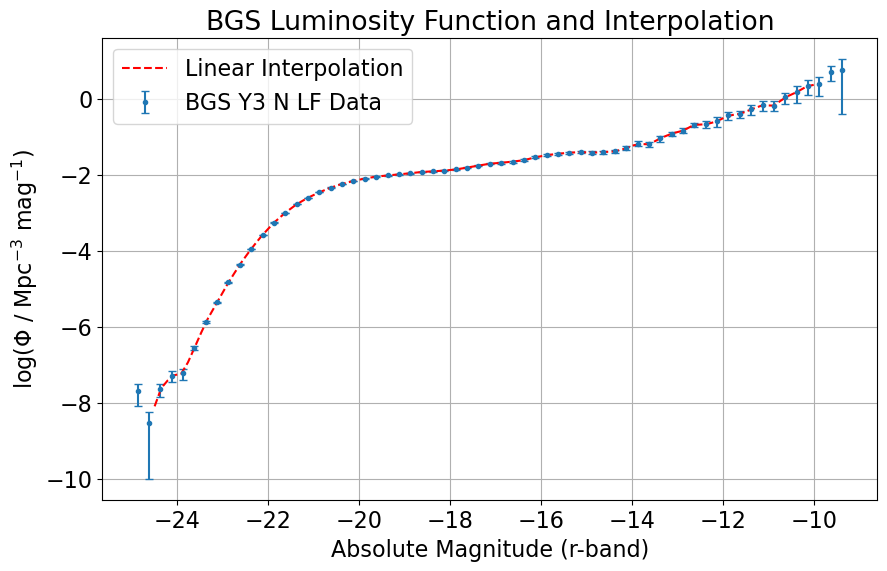

In [49]:
plot_df = df_N[df_N['LOG_PHI'] > -9.9]
y_err = plot_df['LOG_PHI'] - plot_df['LOG_PHI_LOW'], plot_df['LOG_PHI_HI'] - plot_df['LOG_PHI']

def get_log_phi(abs_mag):
    """
    Looks up the log(Phi) value for a given absolute magnitude from the BGS Y3 N LF data,
    using linear interpolation. Throws an error if the magnitude is outside the data range.

    Parameters:
    abs_mag (float or array-like): The absolute magnitude(s) to look up.

    Returns:
    float or array-like: The interpolated log(Phi) value(s).
    """
    # np.interp requires x-coordinates to be increasing. df_N['BIN_CEN'] is decreasing.
    xp = df_N['BIN_CEN'].values
    fp = df_N['LOG_PHI'].values

    # Check if the input is outside the valid range
    if np.any(abs_mag < -24.5) or np.any(abs_mag > -10.0):
        raise ValueError(f"Absolute magnitude must be between {xp[0]:.2f} and {xp[-1]:.2f}.")

    return np.interp(abs_mag, xp, fp)

# Plot to show the interpolation
plt.figure(figsize=(10, 6))
plt.errorbar(plot_df['BIN_CEN'], plot_df['LOG_PHI'], yerr=y_err, fmt='.', capsize=3, label='BGS Y3 N LF Data')
test_mags = np.linspace(-24.5, -10.0, 100)
interpolated_log_phi = get_log_phi(test_mags)
plt.plot(test_mags, interpolated_log_phi, 'r--', label='Linear Interpolation')
plt.xlabel('Absolute Magnitude (r-band)')
plt.ylabel('log($\Phi$ / Mpc$^{-3}$ mag$^{-1}$)')
plt.title('BGS Luminosity Function and Interpolation')
plt.legend()
plt.grid(True)
plt.show()

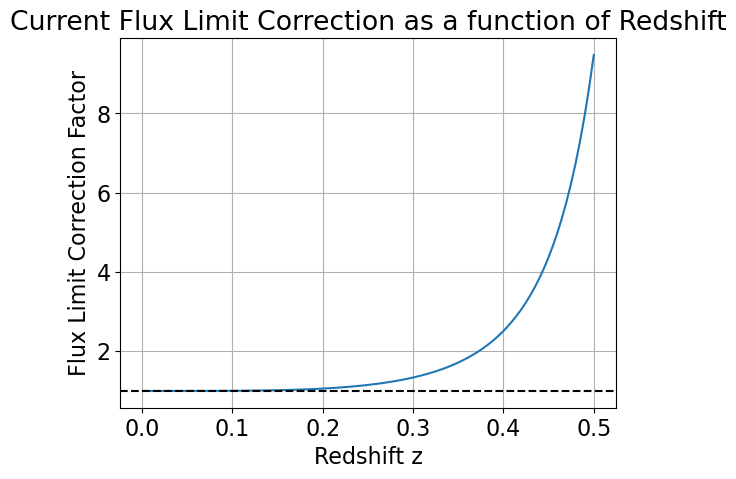

In [69]:
def current_fluxlim_correction(z):
    return np.power(10.0, np.power(z / 0.40, 4.0) * 0.4); # from rho_lum(z) BGS

# PLot it
z = np.linspace(0.001, 0.5, 100)
corrections = current_fluxlim_correction(z)
plt.figure()
plt.plot(z, corrections)
plt.xlabel('Redshift z')
plt.ylabel('Flux Limit Correction Factor')
plt.title('Current Flux Limit Correction as a function of Redshift')
plt.grid()
plt.axhline(1.0, color='k', linestyle='--')
plt.show()
# Horizontal line at 1

/tmp/ipykernel_2327169/3530201880.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_lum_density, _ = quad(luminosity_integrand, m_min, m_max, args=(get_log_phi,))
/tmp/ipykernel_2327169/3530201880.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the int

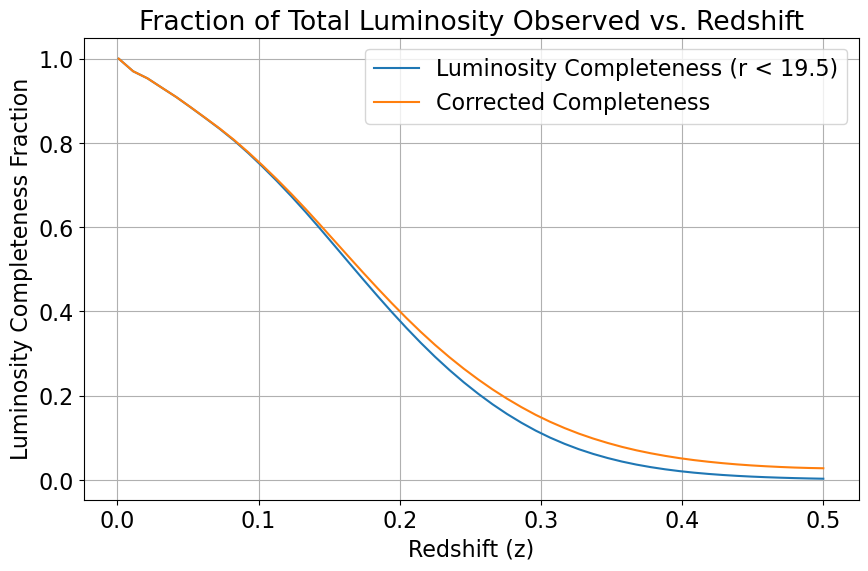

In [ ]:
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad

# --- 1. Setup Cosmology and Constants ---
# Use a standard cosmology. You can adjust this if your LF was derived with different parameters.
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# --- 2. Define the Integrand ---
# The function we want to integrate is the number density Phi(M) times the luminosity L(M).
def luminosity_integrand(M, get_log_phi_func):
    """
    Returns Phi(M) * L(M) for integration.
    M: Absolute magnitude
    get_log_phi_func: The function that returns log10(Phi) for a given M.
    """
    log_phi = get_log_phi_func(M)
    phi = 10**log_phi
    lum = abs_mag_r_to_solar_L(M)
    return phi * lum

# --- 3. Perform the Integration ---
# Define the magnitude range for integration. This should cover the entire range of your LF data.
m_min, m_max = -24.5, -10.0

# Calculate the total possible luminosity density by integrating over all magnitudes.
# The result of quad is (value, error_estimate). We only need the value.
total_lum_density, _ = quad(luminosity_integrand, m_min, m_max, args=(get_log_phi,))

# --- 4. Calculate Completeness vs. Redshift ---
flux_limit = 19.5
redshifts = np.linspace(0.001, 0.5, 50)
lum_completeness = []
factor_needed = []
corrected_completeness = []

for z in redshifts:
    # Calculate luminosity distance in Mpc
    #D_L_Mpc = cosmo.luminosity_distance(z).value
    # Calculate distance modulus
    dist_mod = distmod(z)
    
    # Find the absolute magnitude limit at this redshift for our flux limit
    M_lim = flux_limit - dist_mod
    M_lim = np.clip(M_lim, m_min, m_max)  # Ensure within LF range
    
    # Integrate luminosity down to the observable limit M_lim
    # We integrate from m_min (brightest) to M_lim.
    observed_lum_density, _ = quad(luminosity_integrand, m_min, M_lim, args=(get_log_phi,))
    corrected = observed_lum_density * current_fluxlim_correction(z) / total_lum_density
    
    # The completeness is the ratio of observed to total luminosity
    completeness = observed_lum_density / total_lum_density

    factor_needed.append(total_lum_density / observed_lum_density)
    lum_completeness.append(completeness)
    corrected_completeness.append(corrected)

lum_completeness = np.array(lum_completeness)
factor_needed = np.array(factor_needed)
corrected_completeness = np.array(corrected_completeness)

# --- 5. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(redshifts, lum_completeness, label=f'Luminosity Completeness (r < {flux_limit})')
#plt.plot(redshifts, corrected_completeness, label='Corrected Completeness')
plt.xlabel('Redshift (z)')
plt.ylabel('Luminosity Completeness Fraction')
plt.title('Fraction of Total Luminosity Observed vs. Redshift')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_2327169/2536452713.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  lum_density, _ = quad(luminosity_integrand, m_min, M_lim, args=(get_log_phi,))


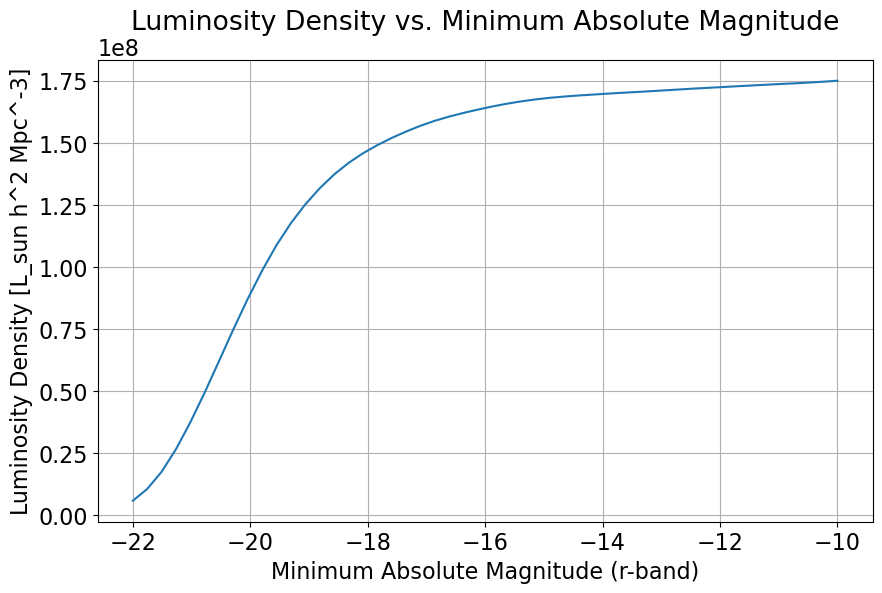

In [ ]:
# This shows that we are weakly dependent on the minimum magnitude limit chosen for the LF integration.

min_mag = np.linspace(-22, -10, 50)
# Plot the luminosity density as a function of min magnitude
lum_densities = []
for M_lim in min_mag:
    lum_density, _ = quad(luminosity_integrand, m_min, M_lim, args=(get_log_phi,))
    lum_densities.append(lum_density)   
plt.figure(figsize=(10, 6))
plt.plot(min_mag, lum_densities)
plt.xlabel('Minimum Absolute Magnitude (r-band)')
plt.ylabel('Luminosity Density [L_sun h^2 Mpc^-3]')
plt.title('Luminosity Density vs. Minimum Absolute Magnitude')
plt.grid(True)
plt.show()

In [71]:
factor_needed

[1.0,
 1.030692494994236,
 1.0489246638370282,
 1.0740365456914662,
 1.1001290971272888,
 1.1303924159404473,
 1.1633064198102565,
 1.198991016723986,
 1.2399992506172979,
 1.2883990929787172,
 1.3447122566591114,
 1.4094015606207844,
 1.4845965155573726,
 1.572579645866591,
 1.6761708938616022,
 1.796903274573272,
 1.937323488153894,
 2.1005521333902735,
 2.290427383883069,
 2.5115915402164366,
 2.769064195039651,
 3.070076859743511,
 3.4215155289960237,
 3.8321364374848317,
 4.315779140571659,
 4.886625117480217,
 5.5694236292703145,
 6.382456467035463,
 7.358243262504026,
 8.540762378254035,
 9.951406224226764,
 11.648757555027395,
 13.709876340194157,
 16.19101032475082,
 19.205663079976716,
 22.914326200079085,
 27.410804865796955,
 32.86009344628511,
 39.529369668004314,
 47.72008478436891,
 57.648003995086995,
 69.74457237793864,
 84.6060922255118,
 102.8940285818304,
 125.1801282274871,
 152.4780945927258,
 186.16688022782537,
 227.97489672085115,
 279.0476516399542,
 341.38874